In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

In [ ]:
expenditures_url='https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/police-annual-statistical-report-gross-expenditures-by-division/resource/845e6bfa-137c-4e3b-a4fe-8f35ee3796e6/download/Gross%20Expenditures%20by%20Division.csv'
reported_crimes_url='https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/police-annual-statistical-report-reported-crimes/resource/900b1303-c7d1-43b8-99e4-d04c7dd4607f/download/Reported%20Crimes.csv'
crime_rates_url='https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/neighbourhood-crime-rates/resource/02898503-a367-4221-9e74-7addb260d110/download/neighbourhood-crime-rates%20-%204326.csv'
discharges_url='https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/4bc5511d-0ecf-487a-9214-7b2359ad8f61/resource/c3083641-5f52-4d92-a68c-b5e67a77710f/download/shootings-firearm-discharges%20-%204326.csv'
arrested_charged_url='https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/police-annual-statistical-report-arrested-and-charged-persons/resource/b4e984de-493b-476c-b8be-60f142312d71/download/Arrested%20and%20Charged%20Persons.csv'
tickets_url='https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/police-annual-statistical-report-tickets-issued/resource/6036d8be-4c37-4fbf-9870-e10ad5bc60d6/download/Tickets%20Issued.csv'

## Expenditures data frame info

In [ ]:
expenditures=pd.read_csv(expenditures_url)
expenditures.head()

,_id,YEAR,CATEGORY,DIVISION,COMMAND,GROSS_EXPENDITURE__FINAL_
0,1,2018,Expenditures,Division 11,West,"$25,553,065.00"
1,2,2018,Expenditures,Division 12,West,"$26,394,439.00"
2,3,2018,Expenditures,Division 14,West,"$33,809,644.00"
3,4,2018,Expenditures,Division 22,West,"$25,078,539.00"
4,5,2018,Expenditures,Division 23,West,"$27,553,169.00"


In [ ]:
expenditures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   _id                        144 non-null    int64 
 1   YEAR                       144 non-null    int64 
 2   CATEGORY                   144 non-null    object
 3   DIVISION                   144 non-null    object
 4   COMMAND                    144 non-null    object
 5   GROSS_EXPENDITURE__FINAL_  144 non-null    object
dtypes: int64(2), object(4)
memory usage: 6.9+ KB


In [ ]:
expenditures['DIVISION'].unique()

array(['Division 11', 'Division 12', 'Division 14', 'Division 22',
       'Division 23', 'Division 31', 'Division 51', 'Division 52',
       'Division 13', 'Division 32', 'Division 33', 'Division 41',
       'Division 42', 'Division 43', 'Division 53', 'Division 55'],
      dtype=object)

## Reported_Crimes data frame info

In [ ]:
reported_crimes=pd.read_csv(reported_crimes_url)
reported_crimes.head()


,_id,REPORT_YEAR,DIVISION,CATEGORY,SUBTYPE,COUNT_,COUNT_CLEARED
0,1,2014,D11,Crimes Against the Person,Other,22,9
1,2,2014,D11,Crimes Against Property,Theft Over $5000,1,1
2,3,2014,D11,Crimes Against the Person,Other,1,1
3,4,2014,D11,Crimes Against the Person,Robbery-Financial,1,1
4,5,2014,D11,Crimes Against Property,Break & Enter-House,23,13


In [ ]:
reported_crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33343 entries, 0 to 33342
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   _id            33343 non-null  int64 
 1   REPORT_YEAR    33343 non-null  int64 
 2   DIVISION       33343 non-null  object
 3   CATEGORY       33343 non-null  object
 4   SUBTYPE        33343 non-null  object
 5   COUNT_         33343 non-null  int64 
 6   COUNT_CLEARED  33343 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 1.8+ MB


In [ ]:
reported_crimes['CATEGORY'].unique()

array(['Crimes Against the Person', 'Crimes Against Property',
       'Controlled Drugs and Substances Act',
       'Other Criminal Code Violations', 'Criminal Code Traffic',
       'Other Federal Statute Violations'], dtype=object)

In [ ]:
reported_crimes['SUBTYPE'].unique()

array(['Other', 'Theft Over $5000', 'Robbery-Financial',
       'Break & Enter-House', 'Break & Enter-Other', 'Auto Theft',
       'Fraud', 'Theft Under $5000', 'Assault', 'Robbery-Other',
       'Break & Enter-Apartment', 'Attempt Murder', 'Sexual Violation',
       'Break & Enter-Commercial',
       'Other Criminal Violations - Offensive Weapons'], dtype=object)

In [ ]:
reported_crimes['DIVISION'].unique()

array(['D11', 'D12', 'D13', 'D14', 'D22', 'D23', 'D31', 'D32', 'D33',
       'D41', 'D42', 'D43', 'D52', 'D51', 'D53', 'D55', 'NSA'],
      dtype=object)

In [ ]:
#NSA stands for Not Specified Area. We'll treat these data points as NaN values:

reported_crimes['DIVISION'] = reported_crimes['DIVISION'].replace('NSA', np.nan)

In [ ]:
#Checking the number of NaN values in the column 'DIVISION'

reported_crimes['DIVISION'].isna().sum()

450

In [ ]:
#We'll imputate the column by distributing NaN-valued rows among other divisions, dependent on their share in the DF

division_counts = reported_crimes['DIVISION'].value_counts()

division_proportions = division_counts / len(reported_crimes) #Calculating the proportion of each division
division_proportions /= division_proportions.sum() #Adjust for any rounding errors

nan_count = reported_crimes['DIVISION'].isna().sum() #Number of NaN values
nan_impute_counts = (division_proportions * nan_count).round().astype(int) #Calculating the number of NaN each division should get

nan_indices = reported_crimes[reported_crimes['DIVISION'].isna()].index

#Imputating NaN values
for idx in nan_indices:
    impute_category = np.random.choice(division_counts.index, p=division_proportions.values)
    reported_crimes.at[idx, 'DIVISION'] = impute_category

In [ ]:
reported_crimes['DIVISION'].isna().sum() #NaN values are imputated

0

## Crime_Rates data frame info

In [ ]:
crime_rates=pd.read_csv(crime_rates_url)
crime_rates.head()

,_id,AREA_NAME,HOOD_ID,POPULATION_2023,ASSAULT_2014,ASSAULT_2015,ASSAULT_2016,ASSAULT_2017,ASSAULT_2018,ASSAULT_2019,...,THEFTOVER_RATE_2015,THEFTOVER_RATE_2016,THEFTOVER_RATE_2017,THEFTOVER_RATE_2018,THEFTOVER_RATE_2019,THEFTOVER_RATE_2020,THEFTOVER_RATE_2021,THEFTOVER_RATE_2022,THEFTOVER_RATE_2023,geometry
0,1,South Eglinton-Davisville,174,21987,63,61,70,82,85,70,...,16.334532,21.590111,5.237247,15.232292,14.822866,24.197842,28.634151,14.006910,36.385136,"{'type': 'MultiPolygon', 'coordinates': [[[[-7..."
1,2,North Toronto,173,15077,45,52,43,52,55,77,...,25.911211,17.305529,16.500288,39.413528,30.234316,43.830814,14.241971,27.502750,46.428333,"{'type': 'MultiPolygon', 'coordinates': [[[[-7..."
2,3,Dovercourt Village,172,13837,56,57,79,94,94,96,...,22.218931,37.180248,22.146759,29.146021,21.698250,21.709240,14.541224,29.008631,21.681000,"{'type': 'MultiPolygon', 'coordinates': [[[[-7..."
3,4,Junction-Wallace Emerson,171,26240,154,157,166,157,157,182,...,20.975794,24.753496,24.404133,27.956388,15.754854,35.254025,31.309929,31.035419,34.298782,"{'type': 'MultiPolygon', 'coordinates': [[[[-7..."
4,5,Yonge-Bay Corridor,170,14731,394,524,487,603,576,660,...,274.197968,233.301651,289.951111,349.539246,481.909271,259.798096,188.651871,358.826416,346.208679,"{'type': 'MultiPolygon', 'coordinates': [[[[-7..."


In [ ]:
crime_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Columns: 185 entries, _id to geometry
dtypes: float64(127), int64(56), object(2)
memory usage: 228.5+ KB


## Discharges data frame info

In [ ]:
discharges=pd.read_csv(discharges_url)
discharges.head()

,_id,EVENT_UNIQUE_ID,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DOW,OCC_DOY,OCC_DAY,OCC_HOUR,OCC_TIME_RANGE,DIVISION,DEATH,INJURIES,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,geometry
0,1,GO-2004133803,NaN,2004,January,Thursday,1,1,0,Night,D31,0,1,23,Pelmo Park-Humberlea,23,Pelmo Park-Humberlea (23),"{'type': 'MultiPoint', 'coordinates': [[-79.53..."
1,2,GO-2004120070,1073-10-06,2004,January,Saturday,3,3,1,Night,D54,0,0,NSA,NSA,NSA,NSA,"{'type': 'MultiPoint', 'coordinates': [[5.6843..."
2,3,GO-2004135509,NaN,2004,January,Sunday,4,4,4,Night,D14,0,2,78,Kensington-Chinatown,78,Kensington-Chinatown (78),"{'type': 'MultiPoint', 'coordinates': [[-79.39..."
3,4,GO-2004126451,NaN,2004,January,Monday,5,5,13,Afternoon,D41,0,1,124,Kennedy Park,124,Kennedy Park (124),"{'type': 'MultiPoint', 'coordinates': [[-79.25..."
4,5,GO-2004136310,NaN,2004,January,Tuesday,6,6,19,Evening,D42,0,0,146,Malvern East,132,Malvern (132),"{'type': 'MultiPoint', 'coordinates': [[-79.20..."


In [ ]:
discharges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6158 entries, 0 to 6157
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   _id                6158 non-null   int64 
 1   EVENT_UNIQUE_ID    6158 non-null   object
 2   OCC_DATE           992 non-null    object
 3   OCC_YEAR           6158 non-null   int64 
 4   OCC_MONTH          6158 non-null   object
 5   OCC_DOW            6158 non-null   object
 6   OCC_DOY            6158 non-null   int64 
 7   OCC_DAY            6158 non-null   int64 
 8   OCC_HOUR           6158 non-null   int64 
 9   OCC_TIME_RANGE     6158 non-null   object
 10  DIVISION           6158 non-null   object
 11  DEATH              6158 non-null   int64 
 12  INJURIES           6158 non-null   int64 
 13  HOOD_158           6158 non-null   object
 14  NEIGHBOURHOOD_158  6158 non-null   object
 15  HOOD_140           6158 non-null   object
 16  NEIGHBOURHOOD_140  6158 non-null   object


In [ ]:
discharges['DIVISION'].unique()

array(['D31', 'D54', 'D14', 'D41', 'D42', 'D32', 'D13', 'D53', 'D23',
       'D33', 'D52', 'D12', 'D22', 'D51', 'D43', 'D11', 'D55'],
      dtype=object)

In [ ]:
discharges['OCC_TIME_RANGE'].unique()

array(['Night', 'Afternoon', 'Evening', 'Morning'], dtype=object)

## Arrested_Charged data frame info

In [ ]:
# Understanding and preparing data
arrested_charged=pd.read_csv(arrested_charged_url)
arrested_charged.head()

,_id,ARREST_YEAR,DIVISION,HOOD_158,NEIGHBOURHOOD_158,SEX,AGE_COHORT,AGE_GROUP,CATEGORY,SUBTYPE,ARREST_COUNT
0,1,2019,D14,83,Dufferin Grove (83),Female,25 to 34,Adult,Other Criminal Code Violations,Other,1
1,2,2022,D12,30,Brookhaven-Amesbury (30),Male,<18,Youth,Crimes Against the Person,Assaults,2
2,3,2018,D14,165,Harbourfront-CityPlace (165),Male,18 to 24,Adult,Other Criminal Code Violations,Other,1
3,4,2015,D22,18,New Toronto (18),Male,25 to 34,Adult,Controlled Drugs and Substances Act,Other,3
4,5,2014,D52,78,Kensington-Chinatown (78),Male,25 to 34,Adult,Other Criminal Code Violations,Other,46


In [ ]:
arrested_charged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129374 entries, 0 to 129373
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   _id                129374 non-null  int64 
 1   ARREST_YEAR        129374 non-null  int64 
 2   DIVISION           129374 non-null  object
 3   HOOD_158           129374 non-null  object
 4   NEIGHBOURHOOD_158  129374 non-null  object
 5   SEX                129374 non-null  object
 6   AGE_COHORT         129374 non-null  object
 7   AGE_GROUP          129374 non-null  object
 8   CATEGORY           129374 non-null  object
 9   SUBTYPE            129374 non-null  object
 10  ARREST_COUNT       129374 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 10.9+ MB


In [ ]:
arrested_charged['ARREST_YEAR'].unique()

array([2019, 2022, 2018, 2015, 2014, 2020, 2021, 2016, 2017])

In [ ]:
arrested_charged['DIVISION'].unique()

array(['D14', 'D12', 'D22', 'D52', 'D43', 'D31', 'D33', 'D55', 'D32',
       'D41', 'D11', 'D42', 'NSA', 'D51', 'D53', 'D13', 'D23'],
      dtype=object)

In [ ]:
arrested_charged['HOOD_158'].unique()

array(['83', '30', '165', '18', '78', '164', '143', '133', '22', '166',
       '43', '66', '27', '119', '111', '138', '44', '162', '12', '128',
       '61', '84', '130', 'NSA', '112', '73', '11', '148', '99', '69',
       '134', '158', '135', '125', '168', '96', '25', '120', '113', '90',
       '145', '161', '81', '63', '68', '56', '54', '122', '40', '42',
       '85', '60', '20', '107', '33', '67', '123', '171', '146', '163',
       '170', '53', '149', '79', '144', '97', '159', '70', '129', '7',
       '5', '74', '16', '142', '136', '174', '95', '173', '157', '109',
       '3', '57', '80', '139', '86', '31', '155', '91', '72', '88', '100',
       '153', '115', '87', '140', '154', '59', '106', '23', '110', '34',
       '13', '126', '71', '160', '47', '4', '32', '64', '38', '121',
       '151', '55', '124', '37', '167', '15', '21', '50', '62', '1',
       '169', '172', '36', '108', '49', '29', '92', '35', '152', '98',
       '101', '118', '147', '141', '156', '9', '28', '10', '52', '24'

In [ ]:
# Find what Neighborhood appears  most often in the dataset
hood_counts = arrested_charged['HOOD_158'].value_counts()
print(hood_counts)

HOOD_158
NSA    3765
78     1826
27     1704
168    1674
164    1640
       ... 
56      376
49      376
103     367
97      313
105     308
Name: count, Length: 159, dtype: int64


In [ ]:
# NSA means Not Specified Area
# We decided to equally split NSA value between all Neighborhoods

# Define the NSA value
nsa_value = 3765
#defining num_neighborhoods
num_neighborhoods=158
# Calculate the fraction of NSA value for each neighborhood
fraction = 1 / num_neighborhoods

# Map neighborhoods to their NSA values
nsa_mapping = {neighborhood: fraction for neighborhood in arrested_charged['HOOD_158'].unique()}
arrested_charged['NSA'] = arrested_charged['HOOD_158'].map(nsa_mapping)

# Print the unique 'NSA' values to verify the update
print(arrested_charged['NSA'].unique())

[0.00632911]


In [ ]:
# This means that each Neighborhood should receive 0.63% of NSA value

In [ ]:
arrested_charged_url='https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/police-annual-statistical-report-arrested-and-charged-persons/resource/b4e984de-493b-476c-b8be-60f142312d71/download/Arrested%20and%20Charged%20Persons.csv'

# Updating dataset
import numpy as np
import pandas as pd
arrested_charged=pd.read_csv(arrested_charged_url)

#Initializing uplift value
uplift_value=3765*0.00632911

# Convert 'HOOD_158' column to numeric, replacing 'NSA' with NaN
arrested_charged['HOOD_158'] = pd.to_numeric(arrested_charged['HOOD_158'], errors='coerce')

# Round the uplift value to the nearest integer
rounded_uplift_value = round(uplift_value)

# Calculate the rounding error
rounding_error = rounded_uplift_value - uplift_value

# Update the 'HOOD_158' column by adding the rounded uplift value and removing 'NSA' values
arrested_charged['HOOD_158'] = arrested_charged['HOOD_158'].fillna(0) + rounded_uplift_value

# Adjust one of the values to compensate for the rounding error
arrested_charged.loc[arrested_charged['HOOD_158'] != 0, 'HOOD_158'] -= rounding_error

# Convert 'HOOD_158' column to integer type
arrested_charged['HOOD_158'] = arrested_charged['HOOD_158'].astype(int)

# Print the 'HOOD_158' column
print(arrested_charged['HOOD_158'])

0         106
1          53
2         188
3          41
4         101
         ... 
129369    167
129370    101
129371    103
129372    177
129373    136
Name: HOOD_158, Length: 129374, dtype: int64


In [ ]:
arrested_charged['HOOD_158'].unique()

array([106,  53, 188,  41, 101, 187, 166, 156,  45, 189,  66,  89,  50,
       142, 134, 161,  67, 185,  35, 151,  84, 107, 153,  23, 135,  96,
        34, 171, 122,  92, 157, 181, 158, 148, 191, 119,  48, 143, 136,
       113, 168, 184, 104,  86,  91,  79,  77, 145,  63,  65, 108,  83,
        43, 130,  56,  90, 146, 194, 169, 186, 193,  76, 172, 102, 167,
       120, 182,  93, 152,  30,  28,  97,  39, 165, 159, 197, 118, 196,
       180, 132,  26,  80, 103, 162, 109,  54, 178, 114,  95, 111, 123,
       176, 138, 110, 163, 177,  82, 129,  46, 133,  57,  36, 149,  94,
       183,  70,  27,  55,  87,  61, 144, 174,  78, 147,  60, 190,  38,
        44,  73,  85,  24, 192, 195,  59, 131,  72,  52, 115,  58, 175,
       121, 124, 141, 170, 164, 179,  32,  51,  33,  75,  47,  62, 117,
        29,  42,  88, 112,  31,  25, 139,  71, 126,  64, 173,  69, 125,
       128,  81, 137])

In [ ]:
arrested_charged['CATEGORY'].unique()

array(['Other Criminal Code Violations', 'Crimes Against the Person',
       'Controlled Drugs and Substances Act', 'Crimes Against Property',
       'Criminal Code Traffic', 'Other Federal Statute Violations',
       'Total Arrests'], dtype=object)

In [ ]:
arrested_charged['SUBTYPE'].unique()

array(['Other', 'Assaults', 'Theft Under $5000', 'Break and Enter',
       'Other Criminal Violations - Offensive Weapons',
       'Drive While Disqualified', 'Drive While Impaired / Over 80',
       'Firearm-Related', 'Fraud', 'Robbery', 'Sexual Violations',
       'Refuse Sample', 'Dangerous Driving', 'Theft Over $5000',
       'Fail to Remain', 'Attempted Murder', 'Total Arrests'],
      dtype=object)

In [ ]:
arrested_charged_url='https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/police-annual-statistical-report-arrested-and-charged-persons/resource/b4e984de-493b-476c-b8be-60f142312d71/download/Arrested%20and%20Charged%20Persons.csv'

# Updating dataset
import numpy as np
import pandas as pd
arrested_charged=pd.read_csv(arrested_charged_url)

# We have some Unknown values for Sex. We decided to split Unknown values proportionally to Male and Female categories
# Let's figure out the proportion of Males and Females assuming all Males plus all Females equall 100%
# Calculate the total number of males and females
total_males = len(arrested_charged[arrested_charged['SEX'] == 'Male'])
total_females = len(arrested_charged[arrested_charged['SEX'] == 'Female'])

# Calculate the total population (excluding 'Unknown' values)
total_population = total_males + total_females

# Calculate the proportion of males in the total population
male_proportion = total_males / total_population

# Fill 'Unknown' values in 'Sex' column with 'male' or 'female' based on proportion
unknown_count = len(arrested_charged[arrested_charged['SEX'] == 'Unknown'])
fill_male_count = int(unknown_count * male_proportion)
fill_female_count = unknown_count - fill_male_count

# Randomly assign 'male' and 'female' based on the calculated proportions
arrested_charged.loc[arrested_charged['SEX'] == 'Unknown', 'SEX'] = np.random.choice(['Male', 'Female'], unknown_count, p=[male_proportion, 1-male_proportion])

# Print the male proportion
print("Male Proportion:", male_proportion)

Male Proportion: 0.7056460992137951


In [ ]:
# Given counts
male_count = 91010
female_count = 37964
unknown_count = 400

# Given proportions
male_proportion = 0.71
female_proportion = 0.29

# Calculate the number of Unknown values to assign to Male and Female proportionally
unknown_male = int(unknown_count * male_proportion)
unknown_female = int(unknown_count * female_proportion)

# Update the counts of Male and Female with the split 'Unknown' values
male_count += unknown_male
female_count += unknown_female

# Print the updated counts
print("Updated Male Count:", male_count)
print("Updated Female Count:", female_count)

Updated Male Count: 91294
Updated Female Count: 38079


In [ ]:
# In this section we do the correlation analyse testing the following hypothesis:
# Hypothesis 1: Incidents of crime that are defined by CATEGORY vary by location which is defined by the variable HOOD_158.
# Hypothesis 2: Number of arrests defined by the variable ARREST_COUNT vary by location which is defined by the variable HOOD_158.
# Hypothesis 3: Certain groups of population that are defined by the variable AGE_GROUP are more inclined to commit a crime than other groups.
# Hypothesis 4: Males as opposed to Females which is defined by the variable SEX are more inclined to commit a crime.
# Hypothesis 5: Certain types of crimes that are defined by the variables CATEGORY are more prevalent in certain locations defined by the variable HOOD_158.

In [ ]:
# For further analysis str attribute Sex must to be converted to Boolean. Let's check if we have SEX values in all records
print(arrested_charged['SEX'].value_counts())

SEX
Male      91275
Female    38099
Name: count, dtype: int64


In [ ]:
# Converting SEX to Boolean for futher correlation analysis
arrested_charged['SEX_BOOLEAN'] = arrested_charged['SEX'].map({'Male': True, 'Female': False}).fillna(arrested_charged['SEX'])

# Print mapping of original SEX values to boolean
print("Mapping of original SEX values to boolean:")
print(arrested_charged[['SEX', 'SEX_BOOLEAN']].drop_duplicates())

Mapping of original SEX values to boolean:
      SEX  SEX_BOOLEAN
0  Female        False
1    Male         True


In [ ]:
# Let's check Age Group
arrested_charged['AGE_GROUP'].unique()
print(arrested_charged['AGE_GROUP'].value_counts())

AGE_GROUP
Adult      115570
Youth       13795
Unknown         9
Name: count, dtype: int64


In [ ]:
# Now, let's deal with CATEGORY
# When calculating the correlation between two variables, the variables should be numeric.
# Since CATEGORY is a string data in our DataFrame we need to convert it into numeric form before calculating the correlation
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the CATEGORY column
arrested_charged['CATEGORY_NUMERIC'] = label_encoder.fit_transform(arrested_charged['CATEGORY'])

# Print the mapping of original and converted values
print("Mapping of original and numeric values:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category}: {i}")

# Print the first few rows of the DataFrame with the new numeric column
print(arrested_charged[['CATEGORY', 'CATEGORY_NUMERIC']].head())


Mapping of original and numeric values:
Controlled Drugs and Substances Act: 0
Crimes Against Property: 1
Crimes Against the Person: 2
Criminal Code Traffic: 3
Other Criminal Code Violations: 4
Other Federal Statute Violations: 5
Total Arrests: 6
                              CATEGORY  CATEGORY_NUMERIC
0       Other Criminal Code Violations                 4
1            Crimes Against the Person                 2
2       Other Criminal Code Violations                 4
3  Controlled Drugs and Substances Act                 0
4       Other Criminal Code Violations                 4


In [ ]:
# Converting AGE_GROUP to Boolean
arrested_charged['AGE_GROUP_BOOLEAN'] = arrested_charged['AGE_GROUP'].replace({'Adult': True, 'Youth': False})

# Print mapping of original SEX values to boolean
print("Mapping of original AGE_GROUP values to boolean:")
print(arrested_charged[['AGE_GROUP', 'AGE_GROUP_BOOLEAN']].drop_duplicates())

Mapping of original AGE_GROUP values to boolean:
    AGE_GROUP AGE_GROUP_BOOLEAN
0       Adult              True
1       Youth             False
481   Unknown           Unknown


In [ ]:
# Let's validate the results for further analysis
print(arrested_charged.head())
print(arrested_charged.describe())

   _id  ARREST_YEAR DIVISION HOOD_158             NEIGHBOURHOOD_158     SEX  \
0    1         2019      D14       83           Dufferin Grove (83)  Female   
1    2         2022      D12       30      Brookhaven-Amesbury (30)    Male   
2    3         2018      D14      165  Harbourfront-CityPlace (165)    Male   
3    4         2015      D22       18              New Toronto (18)    Male   
4    5         2014      D52       78     Kensington-Chinatown (78)    Male   

  AGE_COHORT AGE_GROUP                             CATEGORY   SUBTYPE  \
0   25 to 34     Adult       Other Criminal Code Violations     Other   
1        <18     Youth            Crimes Against the Person  Assaults   
2   18 to 24     Adult       Other Criminal Code Violations     Other   
3   25 to 34     Adult  Controlled Drugs and Substances Act     Other   
4   25 to 34     Adult       Other Criminal Code Violations     Other   

   ARREST_COUNT  SEX_BOOLEAN  CATEGORY_NUMERIC AGE_GROUP_BOOLEAN  
0             1    

In [ ]:
# In this section we are doing the analysis and testing the following hypothesis:


In [ ]:
# Hypothesis 1: Incidents of crime that are defined by CATEGORY vary by location which is defined by the variable HOOD_158.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode HOOD_158 and CATEGORY columns
label_encoder = LabelEncoder()
arrested_charged['HOOD_158_ENCODED'] = label_encoder.fit_transform(arrested_charged['HOOD_158'])
arrested_charged['CATEGORY_ENCODED'] = label_encoder.fit_transform(arrested_charged['CATEGORY_NUMERIC'])

# Calculate the correlation between the encoded columns
correlation = arrested_charged['HOOD_158_ENCODED'].corr(arrested_charged['CATEGORY_ENCODED'])

print(f"Correlation between 'HOOD_158' and 'CATEGORY': {correlation}")

Correlation between 'HOOD_158' and 'CATEGORY': 0.00405163145543725


In [ ]:
# Conclusion: There is no correlation between the Neighborhood and Category of Crime.

In [ ]:
# Hypothesis 2: Number of arrests defined by the variable ARREST_COUNT vary by location which is defined by the variable HOOD_158.

In [ ]:
# Calculate the correlation between 'HOOD_158' and 'ARREST_COUNT'
correlation = arrested_charged['HOOD_158_ENCODED'].corr(arrested_charged['ARREST_COUNT'])

print(f"Correlation between 'HOOD_158' and 'ARREST_COUNT': {correlation}")

Correlation between 'HOOD_158' and 'ARREST_COUNT': -0.01541881611767727


In [ ]:
# Conclusion: There is very light positive correlation between the Neighborhood and the number of Arrests

In [ ]:
# Hypothesis 3: Certain groups of population that are defined by the variable AGE_GROUP are more inclined to commit a crime than other groups.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Converting AGE_GROUP to Boolean
arrested_charged['AGE_GROUP_BOOLEAN'] = arrested_charged['AGE_GROUP'].replace({'Adult': 'True', 'Youth': 'False'})

# Encode the AGE_GROUP column
arrested_charged['AGE_GROUP_ENCODED'] = label_encoder.fit_transform(arrested_charged['AGE_GROUP_BOOLEAN'])

# Calculate the correlation between AGE_GROUP_ENCODED and ARREST_COUNT
correlation = arrested_charged['AGE_GROUP_ENCODED'].corr(arrested_charged['ARREST_COUNT'])

# Print the correlation
print(f"Correlation between AGE_GROUP and ARREST_COUNT: {correlation}")



Correlation between AGE_GROUP and ARREST_COUNT: 0.04782750441219686


In [ ]:
# Conclusion: There is no correlation between the the Age Group and the number of Arrests

In [ ]:
# # Hypothesis 4: Males as opposed to Females which is defined by the variable SEX are more inclined to commit a crime.

In [ ]:
# Calculate the correlation between SEX_BOOLEAN and ARREST_COUNT
correlation = arrested_charged['SEX_BOOLEAN'].corr(arrested_charged['ARREST_COUNT'])

# Print the correlation
print(f"Correlation between 'SEX_BOOLEAN' and 'ARREST_COUNT': {correlation}")

Correlation between 'SEX_BOOLEAN' and 'ARREST_COUNT': 0.113892557746135


In [ ]:
# Conclusion: There is no correlation between the SEX and the number of Arrests

In [ ]:
# Hypothesis 5: Certain types of crimes that are defined by the variables CATEGORY are more prevalent in certain locations defined by the variable HOOD_158.

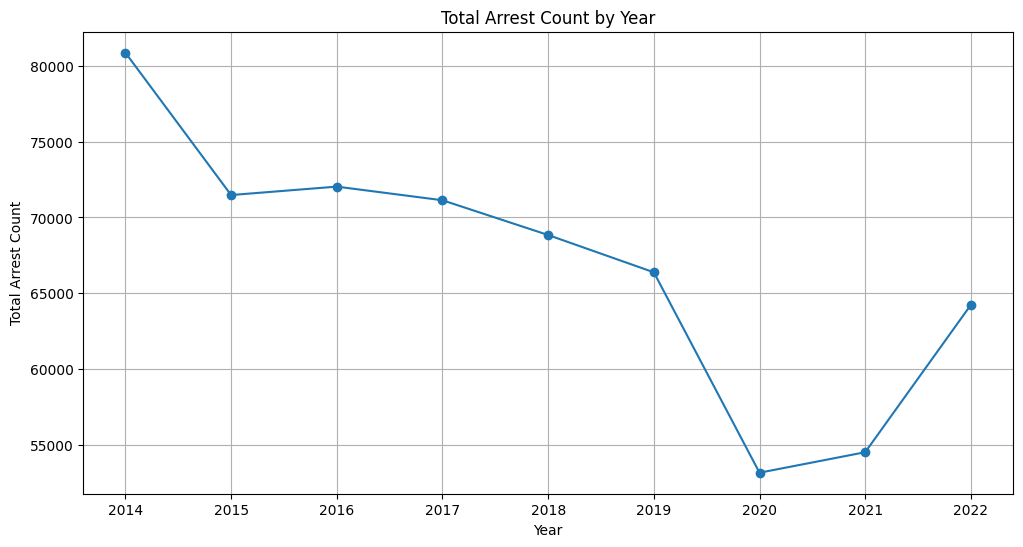

In [ ]:
#Let's visually analyse how ARREST_COUNT changes over time (ARREST_YEAR)

import matplotlib.pyplot as plt

# Group by ARREST_YEAR and sum ARREST_COUNT for each year
arrests_by_year = arrested_charged.groupby('ARREST_YEAR')['ARREST_COUNT'].sum()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(arrests_by_year.index, arrests_by_year.values, marker='o')
plt.title('Total Arrest Count by Year')
plt.xlabel('Year')
plt.ylabel('Total Arrest Count')
plt.grid(True)
plt.show()

In [ ]:
#Conclusion: Overtime the crime rate has been diminising with significant drop during the COVID time. After COVID restrictions were lifted the crime rate almost increased to pre-COVID numbers.

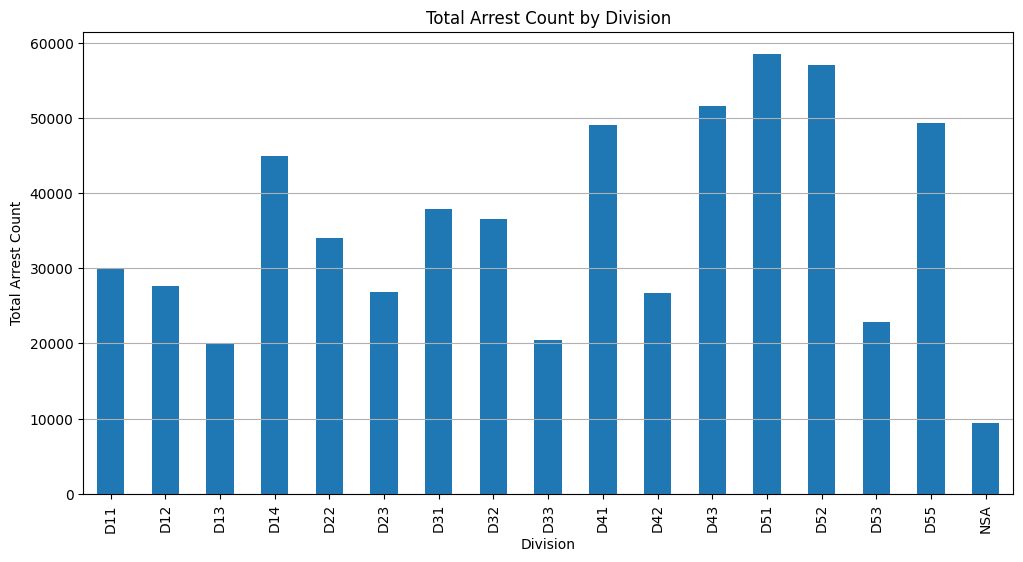

In [ ]:
#Let's plot Arrests by Police Division

# Group by DIVISION and sum ARREST_COUNT for each division
arrests_by_division = arrested_charged.groupby('DIVISION')['ARREST_COUNT'].sum()

# Plotting
plt.figure(figsize=(12, 6))
arrests_by_division.plot(kind='bar')
plt.title('Total Arrest Count by Division')
plt.xlabel('Division')
plt.ylabel('Total Arrest Count')
plt.grid(axis='y')
plt.show()

In [ ]:
#Let's calculate the AVERAGE number of arrests across all Police Divisions

# Calculate the total sum of ARREST_COUNT
total_arrest_count = arrested_charged['ARREST_COUNT'].sum()

# Calculate the number of unique divisions
num_divisions = arrested_charged['DIVISION'].nunique()

# Calculate the mean arrest count across all divisions
mean_arrest_count_division = total_arrest_count / num_divisions

# Print the result
print(f"Mean Arrest Count across all divisions: {mean_arrest_count_division}")

Mean Arrest Count across all divisions: 35452.882352941175


In [ ]:
# Conclusion: Police Divisions D11, 14, 31, 32, 41, 43, 51, 52, 55 tend to arrest above average. The least number of arrests are done by D33, 13, 53.

## Tickets data frame info

In [ ]:
tickets=pd.read_csv(tickets_url)
tickets.head()

,_id,OFFENCE_YEAR,DIVISION,TICKET_TYPE,OFFENCE_CATEGORY,AGE_GROUP,HOOD_158,NEIGHBOURHOOD_158,TICKET_COUNT
0,1,2015,D41,Prov Offence Summons Part Iii Form 104 ...,Other HTA,Youth,121,Oakridge,4
1,2,2020,D42,Prov Offence Notice - Part I (Pot) ...,Other HTA,Youth,148,East L'Amoreaux,5
2,3,2020,D13,Prov Offence Notice - Part I (Pot) ...,Aggressive Driving,Adult,107,Oakwood Village,304
3,4,2021,D22,Prov Offence Summons Part Iii Form 104 ...,Other HTA,Adult,160,Mimico-Queensway,23
4,5,2014,D42,Prov Offence Summons Part Iii Form 104 ...,Aggressive Driving,Adult,116,Steeles,6


In [ ]:
tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23204 entries, 0 to 23203
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   _id                23204 non-null  int64 
 1   OFFENCE_YEAR       23204 non-null  int64 
 2   DIVISION           23204 non-null  object
 3   TICKET_TYPE        23204 non-null  object
 4   OFFENCE_CATEGORY   23204 non-null  object
 5   AGE_GROUP          23204 non-null  object
 6   HOOD_158           23204 non-null  object
 7   NEIGHBOURHOOD_158  23204 non-null  object
 8   TICKET_COUNT       23204 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 1.6+ MB


In [ ]:
# Understanding of the data
tickets['DIVISION'].unique()

array(['D41', 'D42', 'D13', 'D22', 'D32', 'D53', 'D33', 'D52', 'D14',
       'D12', 'D11', 'D55', 'D23', 'D43', 'D31', 'D51', 'NSA'],
      dtype=object)

In [ ]:
tickets['OFFENCE_YEAR'].unique()

array([2015, 2020, 2021, 2014, 2018, 2016, 2017, 2019, 2022])

In [ ]:
tickets['TICKET_TYPE'].unique()

array(['Prov Offence Summons Part Iii Form 104                                         ',
       'Prov Offence Notice - Part I (Pot)                                             '],
      dtype=object)

In [ ]:
tickets['OFFENCE_CATEGORY'].unique()

array(['Other HTA', 'Aggressive Driving', 'Distracted Driving',
       'All CAIA', 'Speeding'], dtype=object)

In [ ]:
tickets['AGE_GROUP'].unique()

array(['Youth', 'Adult', 'Unknown'], dtype=object)

In [ ]:
tickets['HOOD_158'].unique()

array(['121', '148', '107', '160', '116', '40', '27', '41', '8', '126',
       '167', '31', '149', '165', '162', '119', 'NSA', '115', '85', '9',
       '34', '69', '133', '59', '123', '80', '18', '29', '163', '146',
       '11', '151', '53', '78', '173', '144', '37', '13', '48', '130',
       '19', '60', '16', '155', '164', '124', '99', '47', '96', '168',
       '91', '101', '36', '143', '103', '118', '23', '55', '46', '100',
       '65', '136', '10', '54', '49', '63', '142', '73', '24', '174',
       '171', '89', '135', '102', '22', '21', '33', '161', '156', '172',
       '44', '94', '87', '129', '108', '4', '111', '150', '109', '1',
       '62', '122', '43', '152', '158', '140', '25', '3', '71', '58',
       '83', '15', '120', '2', '74', '12', '30', '32', '90', '84', '70',
       '169', '81', '52', '88', '141', '153', '56', '28', '66', '145',
       '79', '64', '50', '157', '138', '42', '39', '38', '166', '105',
       '95', '112', '114', '128', '125', '113', '6', '98', '68', '147',


In [ ]:
# Let's first clean the data.
# There is NSA value in Police Divisions. Let's check how many values are in this NSA and how many tickets are issued by NSA Division.
# Count the total number of NSA values in the DIVISION
total_nsa_values = tickets[tickets['DIVISION'] == 'NSA']['_id'].count()

# Sum the TICKET_COUNT values for all rows where DIVISION is NSA
total_nsa_tickets = tickets[tickets['DIVISION'] == 'NSA']['TICKET_COUNT'].sum()

# Print the total number of NSA values and the total number of tickets done by the NSA division
print(f"Total 'NSA' values in Police DIVISIONS: {total_nsa_values}")
print(f"Total number of tickets done by the 'NSA division': {total_nsa_tickets}")

Total 'NSA' values in Police DIVISIONS: 418
Total number of tickets done by the 'NSA division': 209878


In [ ]:
# We decided to uplift each Division with equal number of tickets from NSA
# Calculate the ticket uplift value
ticket_uplift = total_nsa_tickets / total_nsa_values

# Exclude the NSA division from the DataFrame
non_nsa_tickets = tickets[tickets['DIVISION'] != 'NSA']

# Group by DIVISION and sum the TICKET_COUNT for each Division
division_ticket_counts = non_nsa_tickets.groupby('DIVISION')['TICKET_COUNT'].sum()

# Add the ticket uplift to the TICKET_COUNT for each Division and round to zero decimals
division_ticket_counts_with_uplift = (division_ticket_counts + ticket_uplift).round(0)

# Print DIVISION and TICKET_COUNT with uplift for each Division to validate the redistribution of NSA values
print(division_ticket_counts_with_uplift)

DIVISION
D11     76475.0
D12     81027.0
D13     96192.0
D14    122598.0
D22    101167.0
D23    113882.0
D31    110754.0
D32    114885.0
D33     98587.0
D41    127183.0
D42    138143.0
D43    114660.0
D51     91777.0
D52     98871.0
D53    121977.0
D55    148169.0
Name: TICKET_COUNT, dtype: float64


In [ ]:
# AGE_GROUP has Unknown value
# Let's check if we have AGE_GROUP values in all records
print(tickets['AGE_GROUP'].value_counts())

AGE_GROUP
Adult      18618
Youth       4531
Unknown       55
Name: count, dtype: int64


In [ ]:
# Let's assign these 55 Unknown values to the dominant Category of Adults
# Check the count of each AGE_GROUP value before updating
print("Before update:")
print(tickets['AGE_GROUP'].value_counts())

# Assign the 49 Unknown values to the Adult AGE_GROUP
tickets.loc[tickets['AGE_GROUP'] == 'Unknown', 'AGE_GROUP'] = 'Adult'

# Print the count of AGE_GROUP values after updating for validation
print("\nAfter update:")
print(tickets['AGE_GROUP'].value_counts())

Before update:
AGE_GROUP
Adult      18618
Youth       4531
Unknown       55
Name: count, dtype: int64

After update:
AGE_GROUP
Adult    18673
Youth     4531
Name: count, dtype: int64


In [ ]:
# Converting AGE_GROUP to Boolean
tickets['AGE_GROUP_BOOLEAN'] = tickets['AGE_GROUP'].replace({'Adult': True, 'Youth': False})

# Print mapping of original SEX values to boolean
print("Mapping of original AGE_GROUP values to boolean:")
print(tickets[['AGE_GROUP', 'AGE_GROUP_BOOLEAN']].drop_duplicates())

Mapping of original AGE_GROUP values to boolean:
  AGE_GROUP  AGE_GROUP_BOOLEAN
0     Youth              False
2     Adult               True


In [ ]:
# let's deal with OFFENCE_CATEGORY
# When calculating the correlation between two variables, the variables should be numeric.
# Since OFFENCE_CATEGORY is a string data in our dataset we need to convert it into numeric form before calculating the correlation
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the OFFENCE_CATEGORY column
tickets['OFFENCE_CATEGORY_NUMERIC'] = label_encoder.fit_transform(tickets['OFFENCE_CATEGORY'])

# Print the mapping of original and converted values
print("Mapping of original and numeric values:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category}: {i}")

# Print the first few rows of the DataFrame with the new numeric column
print(tickets[['OFFENCE_CATEGORY', 'OFFENCE_CATEGORY_NUMERIC']].head())

Mapping of original and numeric values:
Aggressive Driving: 0
All CAIA: 1
Distracted Driving: 2
Other HTA: 3
Speeding: 4
     OFFENCE_CATEGORY  OFFENCE_CATEGORY_NUMERIC
0           Other HTA                         3
1           Other HTA                         3
2  Aggressive Driving                         0
3           Other HTA                         3
4  Aggressive Driving                         0


In [ ]:
# In this section we are doing the analysis and testing the following hypothesis:
# Hypothesis 1: Types of Ticket that are defined by OFFENCE_CATEGORY vary by location which is defined by the variable HOOD_158.
# Hypothesis 2: Some police DIVISIONS are more inclined to/or active in issuing tickets than others.
# Hypothesis 3: Adult population as oppose to Youth defined by the variable AGE_GROUP is more inclined to violate rules and receive the tickets.
# Hypothesis 4: Some locations which is defined by the variable HOOD_158 experience more violations resulting in more tickets being issued than others.

In [ ]:
# Hypothesis 1: Types of Ticket that are defined by OFFENCE_CATEGORY vary by location which is defined by the variable HOOD_158.

In [ ]:
# Calculate the correlation between OFFENCE_CATEGORY and HOOD_158
from sklearn.preprocessing import LabelEncoder

# Encode HOOD_158 and CATEGORY columns
label_encoder = LabelEncoder()
tickets['HOOD_158_ENCODED'] = label_encoder.fit_transform(tickets['HOOD_158'])
tickets['CATEGORY_ENCODED'] = label_encoder.fit_transform(tickets['OFFENCE_CATEGORY_NUMERIC'])

# Calculate the correlation between the encoded columns
correlation = tickets['HOOD_158_ENCODED'].corr(tickets['CATEGORY_ENCODED'])

print(f"Correlation between 'HOOD_158' and 'OFFENCE_CATEGORY_NUMERIC': {correlation}")

Correlation between 'HOOD_158' and 'OFFENCE_CATEGORY_NUMERIC': 0.0015803281519150621


In [ ]:
# Conclusion: The correlation value means that there is almost no linear correlation between the categories of offences and the neighbourhoods.
# In other words, knowing the category of offence is not useful for predicting the neighbourhood where the offence happens and vice versa.

In [ ]:
# Hypothesis 2: Some police DIVISIONS are more inclined to/or active in issuing tickets than others.

In [ ]:
# Calculate the correlation between DIVISION and TICKET_COUNT
division_ticket_corr = tickets.groupby('DIVISION')['TICKET_COUNT'].sum().corr(tickets.groupby('DIVISION')['TICKET_COUNT'].sum())

# Print the correlation
print(f'Correlation between DIVISION and TICKET_COUNT: {division_ticket_corr}')

Correlation between DIVISION and TICKET_COUNT: 1.0


In [ ]:
# Conclusion:  A correlation of 1.0 means that there is a perfect positive correlation between the two variables.
# In this case, it indicates that there is a perfect linear relationship between the DIVISION and the number of tickets being issued.

In [ ]:
# Hypothesis 3: Adult population as oppose to Youth defined by the variable AGE_GROUP is more inclined to violate rules and receive the tickets.

In [ ]:
# Calculate the correlation
age_ticket_corr = tickets['AGE_GROUP_BOOLEAN'].corr(tickets['TICKET_COUNT'])

print(f"Correlation between AGE_GROUP_BOOLEAN and TICKET_COUNT: {age_ticket_corr}")

Correlation between AGE_GROUP_BOOLEAN and TICKET_COUNT: 0.11300019463523624


In [ ]:
# Conclusion: A correlation coefficient of 0.305 suggests a weak positive correlation between AGE_GROUP_NUMERIC and TICKET_COUNT.
# The correlation is not strong, indicating that there are other factors influencing the number of tickets issued besides AGE GROUP.

In [ ]:
# Hypothesis 4: Some locations which is defined by the variable HOOD_158 experience more violations resulting in more tickets being issued than others.

In [ ]:
# Test correlation between HOOD_158 and the number of tickets being issued
hood_ticket_corr = tickets.groupby('HOOD_158')['TICKET_COUNT'].sum().corr(tickets.groupby('HOOD_158')['TICKET_COUNT'].sum())

# Print the result
print(f"Correlation between 'HOOD_158' and 'TICKET_COUNT': {hood_ticket_corr}")

Correlation between 'HOOD_158' and 'TICKET_COUNT': 1.0


In [ ]:
# Conclusion:  A correlation of 1.0 means that there is a perfect positive correlation between the two variables.
# In this case, it indicates that in some neighborhoods there is a higher probability to receive the ticket than in others.

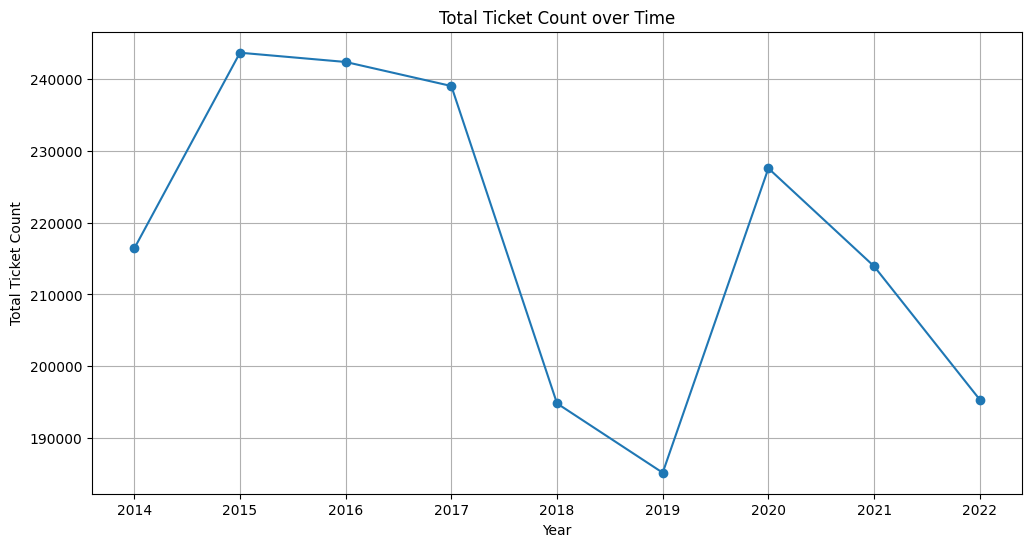

In [ ]:
#Let's visually analyse (plot time series) of how Tickets are issed over time

# Group by 'OFFENCE_YEAR' and sum 'TICKET_COUNT' for each year
ticket_count_yearly = tickets.groupby('OFFENCE_YEAR')['TICKET_COUNT'].sum()

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(ticket_count_yearly.index, ticket_count_yearly.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Ticket Count')
plt.title('Total Ticket Count over Time')
plt.grid(True)
plt.show()


In [ ]:
# Conclusion: Likely the year of 2014 in dataset is not fully covered so we have to exclude it from the analysis.
# This is only the assumption as we don't have Years broken down by Months in our dataset to test this assumption.
# There is a certain tendency to see the number of tickets issued going down over time with the least amount been issued in 2019.

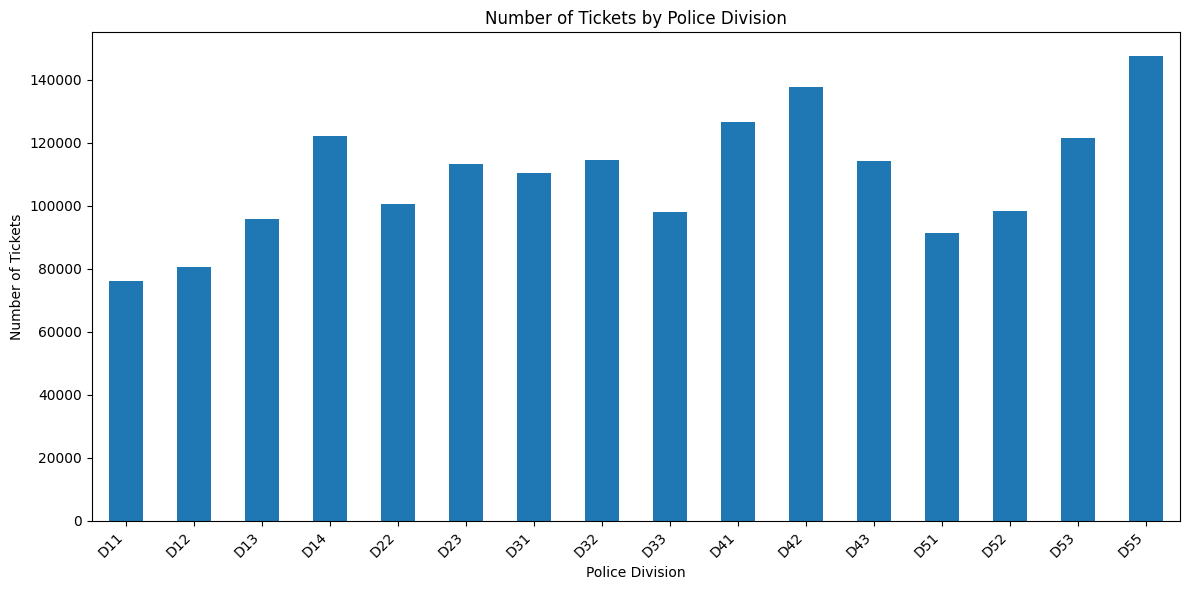

In [ ]:
import matplotlib.pyplot as plt

#Let's plot number of Tickets issued by each Division

# Exclude the 'NSA' division from the DataFrame
non_nsa_tickets = tickets[tickets['DIVISION'] != 'NSA']

# Group by DIVISION and sum the TICKET_COUNT for each division
division_ticket_counts_with_uplift = non_nsa_tickets.groupby('DIVISION')['TICKET_COUNT'].sum()

# Plotting
plt.figure(figsize=(12, 6))
division_ticket_counts_with_uplift.plot(kind='bar')
plt.xlabel('Police Division')
plt.ylabel('Number of Tickets')
plt.title('Number of Tickets by Police Division')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
#Let's calculate the AVERAGE number of tickets issued across all Police Divisions

# Calculate the total sum of TICKET_COUNT
total_ticket_count = tickets['TICKET_COUNT'].sum()

# Calculate the number of unique divisions
num_divisions = tickets['DIVISION'].nunique()

# Calculate the mean arrest count across all divisions
mean_ticket_count_division = total_ticket_count / num_divisions

# Print the result
print(f"Mean Ticket Count across all divisions: {mean_ticket_count_division}")

Mean Ticket Count across all divisions: 115187.82352941176


In [ ]:
# Conclusion: Police Divisions D14, 41, 42, 55 tend to issue tickets above average. The least number of tickets are issued by D11, 12, 51.

In [ ]:
# It should be noted that the correlation analysis is not enough to draw the definitive conclusion about the relationship between the variables.
# It only measures the linear relashionship and can omitt other types of relashionship even if they are strong. Also, it may not imply causation.
# Further statistical analysis (e.g., Chi-squared test) is required but this goes beyond the scope of this project.

 # Analysis of Expenditures

In [ ]:
expenditures.head()

,_id,YEAR,CATEGORY,DIVISION,COMMAND,GROSS_EXPENDITURE__FINAL_
0,1,2018,Expenditures,Division 11,West,"$25,553,065.00"
1,2,2018,Expenditures,Division 12,West,"$26,394,439.00"
2,3,2018,Expenditures,Division 14,West,"$33,809,644.00"
3,4,2018,Expenditures,Division 22,West,"$25,078,539.00"
4,5,2018,Expenditures,Division 23,West,"$27,553,169.00"


In [ ]:
# Getting the data ready ... stripping dollar signs from the expenditure column.

expenditures['EXPENDITURES'] = expenditures['GROSS_EXPENDITURE__FINAL_'].replace('[\$,]', '', regex=True).astype(float)
expenditures.head()

,_id,YEAR,CATEGORY,DIVISION,COMMAND,GROSS_EXPENDITURE__FINAL_,EXPENDITURES
0,1,2018,Expenditures,Division 11,West,"$25,553,065.00",25553065.0
1,2,2018,Expenditures,Division 12,West,"$26,394,439.00",26394439.0
2,3,2018,Expenditures,Division 14,West,"$33,809,644.00",33809644.0
3,4,2018,Expenditures,Division 22,West,"$25,078,539.00",25078539.0
4,5,2018,Expenditures,Division 23,West,"$27,553,169.00",27553169.0


In [ ]:
# Next, let's sort the dataframe by year

expenditures.sort_values(by = "YEAR", inplace = True)
expenditures.head()

,_id,YEAR,CATEGORY,DIVISION,COMMAND,GROSS_EXPENDITURE__FINAL_,EXPENDITURES
72,73,2014,Expenditures,Division 11,Central,"$25,008,526.00",25008526.0
87,88,2014,Expenditures,Division 43,Area,"$29,912,546.00",29912546.0
86,87,2014,Expenditures,Division 42,Area,"$25,808,794.00",25808794.0
85,86,2014,Expenditures,Division 41,Area,"$28,691,149.00",28691149.0
84,85,2014,Expenditures,Division 33,Area,"$20,299,272.00",20299272.0


In [ ]:
# confirm that there is data for every year for each division

print ("There are", len(expenditures['DIVISION'].unique()), "divisions in total.")
expenditures['YEAR'].value_counts()


There are 16 divisions in total.


YEAR
2014    16
2015    16
2016    16
2017    16
2018    16
2019    16
2020    16
2021    16
2022    16
Name: count, dtype: int64

### Testing of Expenditures Hypothesis 1: Police expenditure has seen a gradual increase from 2014 to 2022

Part of the reason for testing this hypothesis has been increased calls to decrease funding over many jurisdictions over the past few years.

In [ ]:
# Let's check the overall trend of police spending in Toronto over this time period.

# Make a new data frame consisting of the year and the total expenditure (for all divisions) in that year
# I start by making two lists (one for the years and one for the total expenditure in that year) and then create a dataframe
# from the lists.

year_list = []
expenditure_list = []


for i in expenditures['YEAR'].unique():
    year_list.append(i)
    expenditure_list.append (expenditures.loc[expenditures['YEAR']==i,['EXPENDITURES']].sum()[0])



total_expenditures = pd.DataFrame({'YEAR':year_list, 'TOTAL_EXPENDITURES':expenditure_list})
total_expenditures.sort_values(by='YEAR', inplace=True)


total_expenditures.head()


,YEAR,TOTAL_EXPENDITURES
0,2014,449585767.0
1,2015,447996716.0
2,2016,465216261.0
3,2017,457785818.0
4,2018,454333999.0


<function matplotlib.pyplot.show(close=None, block=None)>

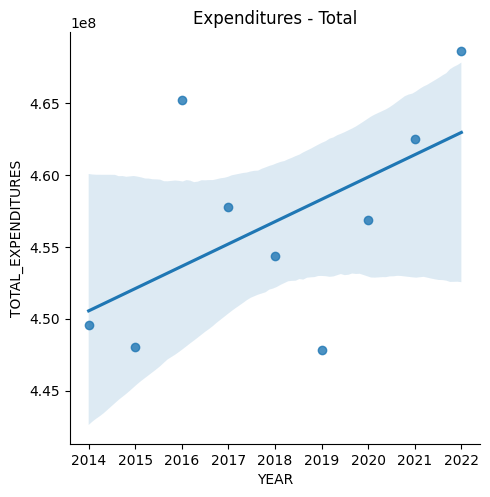

In [ ]:
# We now graph the total expenditures versus year.

sns.lmplot (data=total_expenditures, x = 'YEAR', y = 'TOTAL_EXPENDITURES')
plt.title('Expenditures - Total')
plt.show

In [ ]:
# Let's calculate the slope and r^2 value of this line of best fit

X = total_expenditures['YEAR']
Y = total_expenditures['TOTAL_EXPENDITURES']


# Add a constant so the model will choose an intercept.
X = sm.add_constant(X)


# Fit the OLS model
est = sm.OLS(Y, X).fit()

# Check the results
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     TOTAL_EXPENDITURES   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     3.203
Date:                Thu, 18 Apr 2024   Prob (F-statistic):              0.117
Time:                        08:11:32   Log-Likelihood:                -153.12
No. Observations:                   9   AIC:                             310.2
Df Residuals:                       7   BIC:                             310.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.676e+09   1.75e+09     -1.529      0.170   -6.82e+09    1.46e+09
YEAR        1.552e+06   8.67e+05      1.790      0.117   -4.99e+05     3.6e+06
==============================================================================
Omnibus:                        0.754   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.686   Jarque-Bera (JB):                0.116
Skew:                           0.264   Prob(JB):                        0.943
Kurtosis:                       2.825   Cond. No.                     1.58e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Expenditures Hypothesis 1 - While total expenditure is seeing a slight increase over time, it is only a weak positive correlation (the r^2 value is 0.314).

### Expenditures Hypothesis 2 - All Divisions will follow approximately the same pattern in Expenditures


<function matplotlib.pyplot.show(close=None, block=None)>

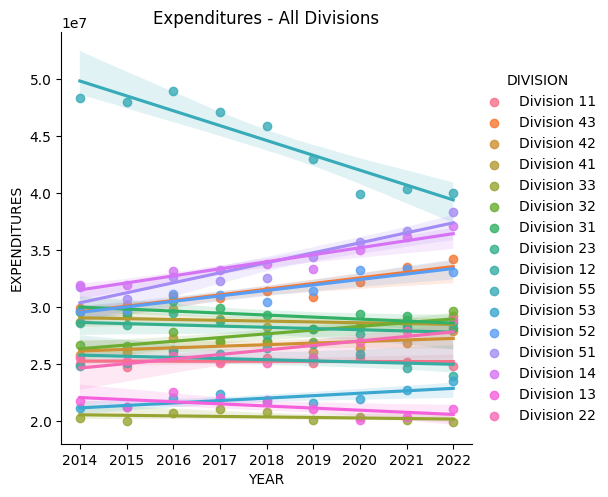

In [ ]:
# Next, we look at expenditure by Division

sns.lmplot (data=expenditures, x = 'YEAR', y = 'EXPENDITURES', hue = 'DIVISION')
plt.title('Expenditures - All Divisions')
plt.show

In [ ]:
expenditures.loc[expenditures['DIVISION']=='Division 55']

,_id,YEAR,CATEGORY,DIVISION,COMMAND,GROSS_EXPENDITURE__FINAL_,EXPENDITURES
79,80,2014,Expenditures,Division 55,Central,"$48,342,794.00",48342794.0
95,96,2015,Expenditures,Division 55,Central,"$48,035,808.00",48035808.0
111,112,2016,Expenditures,Division 55,East,"$48,977,354.00",48977354.0
127,128,2017,Expenditures,Division 55,East,"$47,121,977.00",47121977.0
143,144,2018,Expenditures,Division 55,East,"$45,918,361.00",45918361.0
15,16,2019,Expenditures,Division 55,East,"$43,026,489.00",43026489.0
31,32,2020,Expenditures,Division 55,East,"$39,942,730.00",39942730.0
47,48,2021,Expenditures,Division 55,East,"$40,409,192.00",40409192.0
63,64,2022,Expenditures,Division 55,East,"$40,017,957.00",40017957.0


In [ ]:
# It is clear that Division 55 is behaving very differently than the other divisions.
# Let's calculate the r^2 value for the line of best fit for Division 55

X = expenditures.loc[expenditures['DIVISION']=='Division 55']['YEAR']
Y = expenditures.loc[expenditures['DIVISION']=='Division 55']['EXPENDITURES']

# Add a constant so the model will choose an intercept. (Otherwise the model will fit a line through the origin).
X = sm.add_constant(X)

# Fit the OLS model
est = sm.OLS(Y, X).fit()

# Check the results
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           EXPENDITURES   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     53.11
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           0.000165
Time:                        08:11:40   Log-Likelihood:                -138.93
No. Observations:                   9   AIC:                             281.9
Df Residuals:                       7   BIC:                             282.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.68e+09   3.62e+08      7.411      0.000    1.82e+09    3.53e+09
YEAR       -1.306e+06   1.79e+05     -7.287      0.000   -1.73e+06   -8.82e+05
==============================================================================
Omnibus:                        0.628   Durbin-Watson:                   1.188
Prob(Omnibus):                  0.730   Jarque-Bera (JB):                0.551
Skew:                          -0.234   Prob(JB):                        0.759
Kurtosis:                       1.881   Cond. No.                     1.58e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<function matplotlib.pyplot.show(close=None, block=None)>

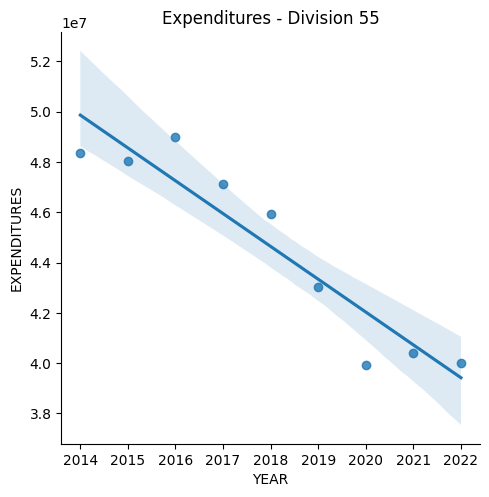

In [ ]:
sns.lmplot (data=expenditures.loc[expenditures['DIVISION']=='Division 55'], x = 'YEAR', y = 'EXPENDITURES')
plt.title('Expenditures - Division 55')
plt.show

### Expenditures Hypothesis 2 Conclusions - Not all divisions are following the same pattern in expenditures.

There is a strong negative correlation for this graph (r^2 = 0.884). While the general trend of police spending has increased over this time period, Division 55 has seen a steady decline in expenditures. Next, let's investigate how crime has varied in Division 55 over this same time period.

In [ ]:
arrested_charged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129374 entries, 0 to 129373
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   _id                129374 non-null  int64 
 1   ARREST_YEAR        129374 non-null  int64 
 2   DIVISION           129374 non-null  object
 3   HOOD_158           129374 non-null  object
 4   NEIGHBOURHOOD_158  129374 non-null  object
 5   SEX                129374 non-null  object
 6   AGE_COHORT         129374 non-null  object
 7   AGE_GROUP          129374 non-null  object
 8   CATEGORY           129374 non-null  object
 9   SUBTYPE            129374 non-null  object
 10  ARREST_COUNT       129374 non-null  int64 
 11  SEX_BOOLEAN        129374 non-null  bool  
 12  CATEGORY_NUMERIC   129374 non-null  int64 
 13  AGE_GROUP_BOOLEAN  129374 non-null  object
 14  HOOD_158_ENCODED   129374 non-null  int64 
 15  CATEGORY_ENCODED   129374 non-null  int64 
 16  AGE_GROUP_ENCODED  1

In [ ]:
arrested_charged['DIVISION'].unique()

array(['D14', 'D12', 'D22', 'D52', 'D43', 'D31', 'D33', 'D55', 'D32',
       'D41', 'D11', 'D42', 'NSA', 'D51', 'D53', 'D13', 'D23'],
      dtype=object)

In [ ]:
arrested_charged_D55 = arrested_charged.loc[arrested_charged['DIVISION']=='D55']
arrested_charged_D55.head()

,_id,ARREST_YEAR,DIVISION,HOOD_158,NEIGHBOURHOOD_158,SEX,AGE_COHORT,AGE_GROUP,CATEGORY,SUBTYPE,ARREST_COUNT,SEX_BOOLEAN,CATEGORY_NUMERIC,AGE_GROUP_BOOLEAN,HOOD_158_ENCODED,CATEGORY_ENCODED,AGE_GROUP_ENCODED
13,14,2021,D55,66,Danforth (66),Female,25 to 34,Adult,Crimes Against the Person,Other,1,False,2,True,126,2,1
18,19,2018,D55,44,Flemingdon Park (44),Male,45 to 54,Adult,Criminal Code Traffic,Drive While Impaired / Over 80,1,True,3,True,104,3,1
23,24,2021,D55,61,Taylor-Massey (61),Male,25 to 34,Adult,Crimes Against the Person,Assaults,11,True,2,True,121,2,1
32,33,2019,D55,69,Blake-Jones (69),Male,18 to 24,Adult,Other Criminal Code Violations,Other,6,True,4,True,129,4,1
46,47,2018,D55,61,Taylor-Massey (61),Male,18 to 24,Adult,Controlled Drugs and Substances Act,Other,3,True,0,True,121,0,1


In [ ]:
crimes = arrested_charged_D55['CATEGORY'].unique()
crimes

array(['Crimes Against the Person', 'Criminal Code Traffic',
       'Other Criminal Code Violations',
       'Controlled Drugs and Substances Act', 'Crimes Against Property',
       'Other Federal Statute Violations', 'Total Arrests'], dtype=object)

In [ ]:
# As an example, we are interested in how the data shown below is changing over our time interval

arrested_charged_D55.loc[arrested_charged_D55['ARREST_YEAR']==2014]['CATEGORY'].value_counts()

CATEGORY
Crimes Against the Person              414
Crimes Against Property                385
Other Criminal Code Violations         262
Total Arrests                          231
Controlled Drugs and Substances Act    128
Criminal Code Traffic                   83
Name: count, dtype: int64

In [ ]:
# Create a new dataframe that shows the number of incidents of each type of crime, by year, for Division 55

# Create the empty dataframe
df_D55 = pd.DataFrame (columns = crimes)
df_D55.drop(['Other Federal Statute Violations'], axis=1, inplace=True)
df_D55['YEAR'] = ""

# Create empty lists that will be populated and then used to create the dataframe
year_list = []
crime_person_list = []
crime_traffic_list = []
crime_other_list = []
crime_drug_list = []
crime_property_list = []
crime_arrests_list = []

# Populate the lists
for i in arrested_charged_D55['ARREST_YEAR'].unique():
    year_list.append(i)
    crime_person_list.append(arrested_charged_D55.loc[arrested_charged_D55['ARREST_YEAR']==i]['CATEGORY'].value_counts()["Crimes Against the Person"])
    crime_traffic_list.append(arrested_charged_D55.loc[arrested_charged_D55['ARREST_YEAR']==i]['CATEGORY'].value_counts()["Criminal Code Traffic"])
    crime_other_list.append(arrested_charged_D55.loc[arrested_charged_D55['ARREST_YEAR']==i]['CATEGORY'].value_counts()["Other Criminal Code Violations"])
    crime_drug_list.append(arrested_charged_D55.loc[arrested_charged_D55['ARREST_YEAR']==i]['CATEGORY'].value_counts()["Controlled Drugs and Substances Act"])
    crime_property_list.append(arrested_charged_D55.loc[arrested_charged_D55['ARREST_YEAR']==i]['CATEGORY'].value_counts()["Crimes Against Property"])
    crime_arrests_list.append(arrested_charged_D55.loc[arrested_charged_D55['ARREST_YEAR']==i]['CATEGORY'].value_counts()["Total Arrests"])

# Populate the dataframe
df_D55['YEAR']=year_list
df_D55['Crimes Against the Person'] = crime_person_list
df_D55['Criminal Code Traffic'] = crime_traffic_list
df_D55['Other Criminal Code Violations'] = crime_other_list
df_D55['Controlled Drugs and Substances Act'] = crime_drug_list
df_D55['Crimes Against Property'] = crime_property_list
df_D55['Total Arrests'] = crime_arrests_list

# Order the dataframe by year
df_D55.sort_values(by=['YEAR'], inplace=True)

df_D55.head()

,Crimes Against the Person,Criminal Code Traffic,Other Criminal Code Violations,Controlled Drugs and Substances Act,Crimes Against Property,Total Arrests,YEAR
3,414,83,262,128,385,231,2014
8,394,98,275,98,381,233,2015
4,392,107,262,101,394,239,2016
5,371,108,265,102,371,230,2017
1,383,97,268,85,369,215,2018


Text(0.5, 1.0, 'Crime Incidents - Division 55')

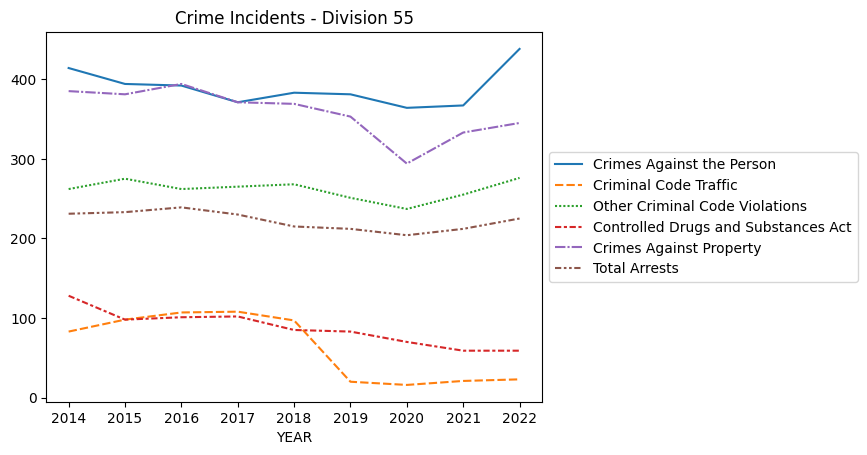

In [ ]:
temp = df_D55.set_index("YEAR")


g = sns.lineplot(data=temp)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Crime Incidents - Division 55')

Rates of different types of crimes are remaining relatively stable in Division 55 over this time period.

#Time analysis



##Time analysis: Expenditures DataFrame


In [ ]:
expenditures.head()

,_id,YEAR,CATEGORY,DIVISION,COMMAND,GROSS_EXPENDITURE__FINAL_,EXPENDITURES
72,73,2014,Expenditures,Division 11,Central,"$25,008,526.00",25008526.0
87,88,2014,Expenditures,Division 43,Area,"$29,912,546.00",29912546.0
86,87,2014,Expenditures,Division 42,Area,"$25,808,794.00",25808794.0
85,86,2014,Expenditures,Division 41,Area,"$28,691,149.00",28691149.0
84,85,2014,Expenditures,Division 33,Area,"$20,299,272.00",20299272.0


In [ ]:
total_expenditures

,YEAR,TOTAL_EXPENDITURES
0,2014,449585767.0
1,2015,447996716.0
2,2016,465216261.0
3,2017,457785818.0
4,2018,454333999.0
5,2019,447851581.0
6,2020,456836801.0
7,2021,462538361.0
8,2022,468639563.0


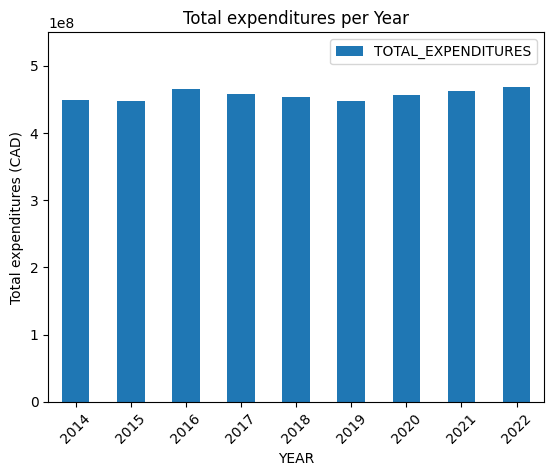

In [ ]:
total_expenditures.plot(kind='bar', x='YEAR', y=['TOTAL_EXPENDITURES'], rot=45)
plt.title('Total expenditures per Year')
plt.ylim(0, 550000000)
plt.ylabel('Total expenditures (CAD)');

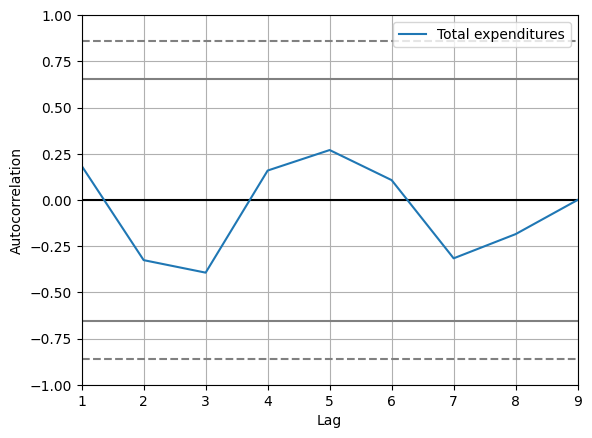

In [ ]:
ACPlot=pd.plotting.autocorrelation_plot(total_expenditures['TOTAL_EXPENDITURES'], label='Total expenditures')

In [ ]:
corr_count_expenditures= total_expenditures['TOTAL_EXPENDITURES'].corr(expenditures['YEAR'])
print(corr_count_expenditures)

0.5874128359726277


The features Total Expenditures and Year exhibit a positive correlation coefficient, indicating that as time progresses, expenditures also tend to increase.

##Time analysis: Reported Crimes DataFrame


In [ ]:
rc_groupby_year=reported_crimes.groupby('REPORT_YEAR')[['COUNT_','COUNT_CLEARED']].sum().reset_index()
rc_groupby_year

,REPORT_YEAR,COUNT_,COUNT_CLEARED
0,2014,113432,58751
1,2015,117365,58308
2,2016,122626,59231
3,2017,129970,59989
4,2018,143204,59222
5,2019,144532,57760
6,2020,118560,41865
7,2021,120366,39170
8,2022,140972,45667


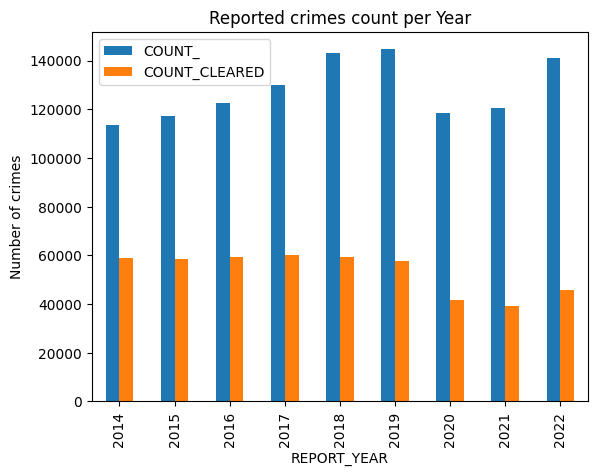

In [ ]:
rc_groupby_year.plot(kind='bar', x='REPORT_YEAR', y=['COUNT_','COUNT_CLEARED'])
plt.title('Reported crimes count per Year');
plt.ylabel('Number of crimes');

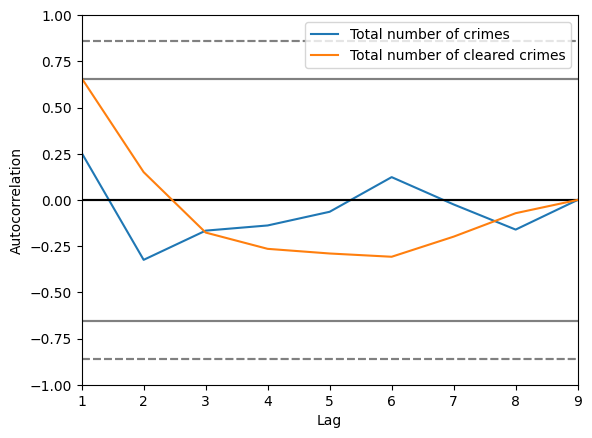

In [ ]:
#Plotting an autocorrelation plot

ACPlot=pd.plotting.autocorrelation_plot(rc_groupby_year['COUNT_'], label='Total number of crimes')
ACPlot=pd.plotting.autocorrelation_plot(rc_groupby_year['COUNT_CLEARED'], label='Total number of cleared crimes')

In [ ]:
#Checking the correlation coefficients

corr_count_rc = rc_groupby_year['COUNT_'].corr(rc_groupby_year['REPORT_YEAR'])
print(corr_count_rc)

corr_cleared_rc_cleared = rc_groupby_year['COUNT_CLEARED'].corr(rc_groupby_year['REPORT_YEAR'])
print(corr_cleared_rc_cleared)

0.4723841719482602
-0.7875774525396007


The positive correlation coefficient for reported crimes indicates that as time progresses, the number of reported crimes also tend to increase.

Unlike reported crimes, cleared crimes have negative correlation coefficient versus time, which shows that as the time progresses, there are fewer cleared crimes.

Investigating the relationship between time and divison data:

In [ ]:
rc_groupby_year_div=reported_crimes.groupby(['REPORT_YEAR','DIVISION'])[['_id']].count().reset_index()
rc_groupby_year_div.rename(columns={'_id': 'COUNT'}, inplace=True)
rc_groupby_year_div

,REPORT_YEAR,DIVISION,COUNT
0,2014,D11,240
1,2014,D12,216
2,2014,D13,225
3,2014,D14,274
4,2014,D22,280
...,...,...,...
139,2022,D43,225
140,2022,D51,167
141,2022,D52,162
142,2022,D53,281


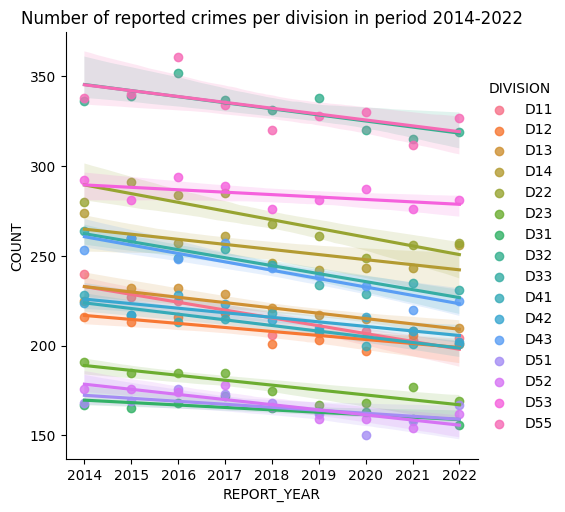

In [ ]:
sns.lmplot(rc_groupby_year_div, x='REPORT_YEAR', y='COUNT', hue='DIVISION')
plt.title('Number of reported crimes per division in period 2014-2022');

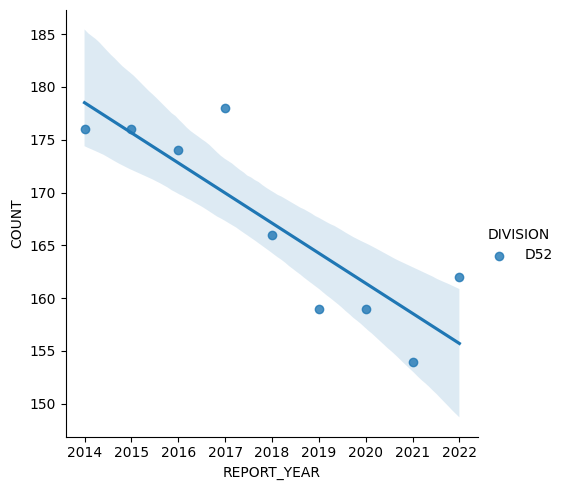

In [ ]:
rc_divv=rc_groupby_year_div[rc_groupby_year_div['DIVISION']=='D52']
sns.lmplot(rc_divv, x='REPORT_YEAR', y='COUNT', hue='DIVISION')

Investigating the relationship between time and category data:

In [ ]:
rc_crosstab = pd.crosstab(reported_crimes["REPORT_YEAR"], reported_crimes["CATEGORY"])
rc_crosstab

CATEGORY,Controlled Drugs and Substances Act,Crimes Against Property,Crimes Against the Person,Criminal Code Traffic,Other Criminal Code Violations,Other Federal Statute Violations
REPORT_YEAR,,,,,,
2014,219,1819,1032,221,440,141
2015,219,1801,1014,215,448,135
2016,215,1819,1024,217,459,128
2017,215,1800,1024,213,464,113
2018,198,1736,1000,200,433,96
2019,179,1778,953,204,405,100
2020,169,1768,925,206,409,90
2021,178,1746,885,220,425,77
2022,155,1790,932,214,418,59


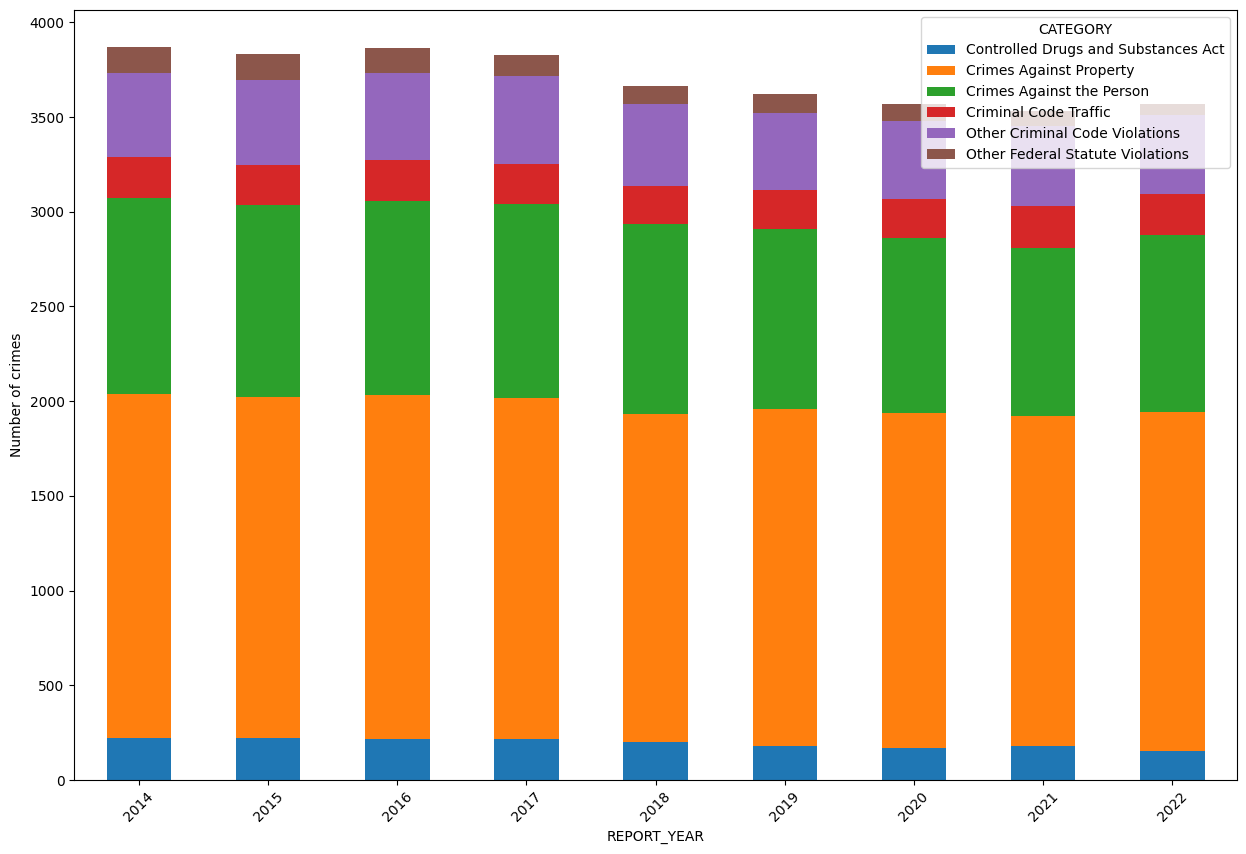

In [ ]:
rc_crosstab.plot(kind='bar', stacked=True, figsize=(15,10), rot=45);
plt.ylabel('Number of crimes');

##Time Analysis: Tickets DataFrame

In [ ]:
tickets['DIVISION'].unique()

array(['D41', 'D42', 'D13', 'D22', 'D32', 'D53', 'D33', 'D52', 'D14',
       'D12', 'D11', 'D55', 'D23', 'D43', 'D31', 'D51', 'NSA'],
      dtype=object)

In [ ]:
tickets['DIVISION'].value_counts()

DIVISION
D32    2097
D55    1980
D33    1806
D53    1737
D22    1640
D42    1572
D43    1528
D41    1361
D13    1313
D14    1278
D23    1266
D11    1212
D12    1197
D31    1045
D51     893
D52     861
NSA     418
Name: count, dtype: int64

In [ ]:
#Imputation for 'NSA' values in 'DIVISION' column:

#Replacing 'NSA' with NaN
tickets['DIVISION']=tickets['DIVISION'].replace('NSA', np.nan)

division_counts_tickets=tickets['DIVISION'].value_counts()

#Calculating the proportion of each division
division_proportions_tickets = division_counts_tickets/len(tickets)

#Adjust for any rounding errors
division_proportions_tickets /= division_proportions_tickets.sum()

#Number of NaN values
nan_count_tickets_div = tickets['DIVISION'].isna().sum()

#Calculating the number of NaN each division should get
nan_impute_tickets_div= (division_proportions_tickets * nan_count_tickets_div).round().astype(int)

nan_indices_tickets_div = tickets[tickets['DIVISION'].isna()].index

for idx in nan_indices_tickets_div:
  impute_category = np.random.choice(division_counts_tickets.index, p=division_proportions_tickets.values)
  tickets.at[idx, 'DIVISION'] = impute_category

In [ ]:
#NaN values are imputated
tickets['DIVISION'].isna().sum()

0

In [ ]:
tickets.sort_values(by='OFFENCE_YEAR')

,_id,OFFENCE_YEAR,DIVISION,TICKET_TYPE,OFFENCE_CATEGORY,AGE_GROUP,HOOD_158,NEIGHBOURHOOD_158,TICKET_COUNT,AGE_GROUP_BOOLEAN,OFFENCE_CATEGORY_NUMERIC,HOOD_158_ENCODED,CATEGORY_ENCODED
3459,3460,2014,D53,Prov Offence Notice - Part I (Pot) ...,Speeding,Adult,96,Casa Loma,4,True,4,154,4
18084,18085,2014,D42,Prov Offence Notice - Part I (Pot) ...,Aggressive Driving,Adult,118,Tam O'Shanter-Sullivan,223,True,0,19,0
18070,18071,2014,D55,Prov Offence Notice - Part I (Pot) ...,Other HTA,Adult,62,East End-Danforth,340,True,3,122,3
11553,11554,2014,D22,Prov Offence Summons Part Iii Form 104 ...,Aggressive Driving,Adult,160,Mimico-Queensway,3,True,0,61,0
2190,2191,2014,D14,Prov Offence Summons Part Iii Form 104 ...,Aggressive Driving,Adult,85,South Parkdale,3,True,0,143,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21037,21038,2022,D43,Prov Offence Notice - Part I (Pot) ...,Speeding,Youth,136,West Hill,5,False,4,36,4
15390,15391,2022,D12,Prov Offence Notice - Part I (Pot) ...,Other HTA,Adult,90,Junction Area,242,True,3,149,3
15389,15390,2022,D14,Prov Offence Notice - Part I (Pot) ...,Speeding,Adult,81,Trinity-Bellwoods,15,True,4,140,4
21027,21028,2022,D32,Prov Offence Notice - Part I (Pot) ...,Aggressive Driving,Youth,32,Englemount-Lawrence,1,False,0,91,0


In [ ]:
tickets_groupby_year=tickets.groupby('OFFENCE_YEAR')[['TICKET_COUNT']].sum().reset_index()
tickets_groupby_year

,OFFENCE_YEAR,TICKET_COUNT
0,2014,216399
1,2015,243603
2,2016,242317
3,2017,238974
4,2018,194851
5,2019,185217
6,2020,227534
7,2021,213916
8,2022,195382


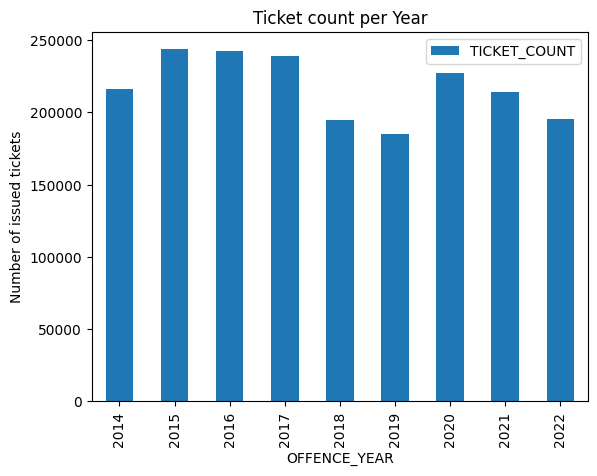

In [ ]:
tickets_groupby_year.plot(kind='bar', x='OFFENCE_YEAR', y='TICKET_COUNT')
plt.title('Ticket count per Year')
plt.ylabel('Number of issued tickets');

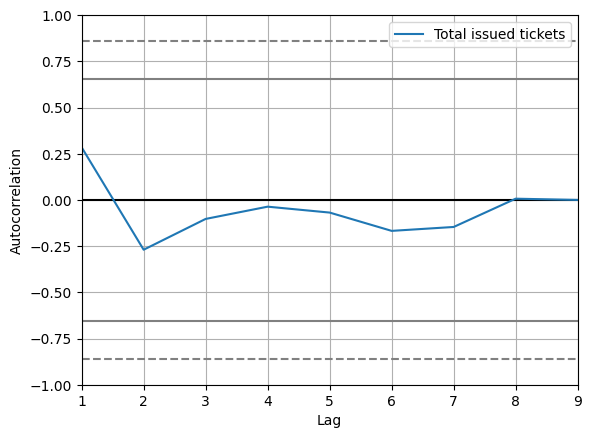

In [ ]:
ACPlot_tickets=pd.plotting.autocorrelation_plot(tickets_groupby_year['TICKET_COUNT'], label='Total issued tickets')

In [ ]:
corr_count_tickets = tickets_groupby_year['TICKET_COUNT'].corr(tickets_groupby_year['OFFENCE_YEAR'])
corr_count_tickets

-0.5289676587164309

The negative correlation coefficient for Number of issued tickets vs. Year indicates that as time progresses, the number of issued tickets tend to decrease.

In [ ]:
tickets_groupby_year_div=tickets.groupby(['OFFENCE_YEAR','DIVISION'])[['_id']].count().reset_index()
tickets_groupby_year_div.rename(columns={'_id':'COUNT'}, inplace=True)
tickets_groupby_year_div

,OFFENCE_YEAR,DIVISION,COUNT
0,2014,D11,131
1,2014,D12,132
2,2014,D13,157
3,2014,D14,143
4,2014,D22,163
...,...,...,...
139,2022,D43,168
140,2022,D51,104
141,2022,D52,98
142,2022,D53,180


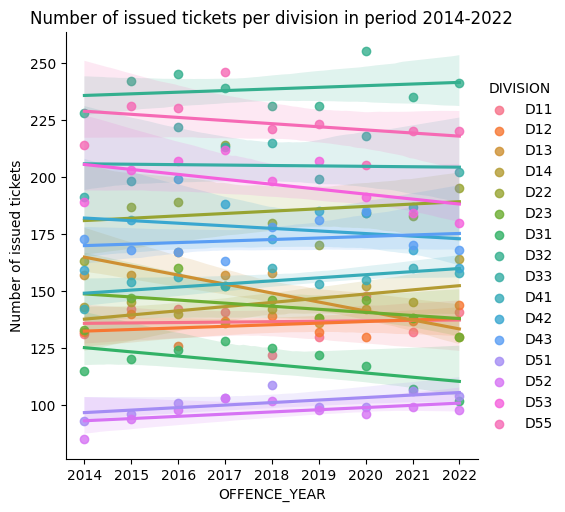

In [ ]:
sns.lmplot(tickets_groupby_year_div, x='OFFENCE_YEAR', y='COUNT', hue='DIVISION')
plt.title('Number of issued tickets per division in period 2014-2022')
plt.ylabel('Number of issued tickets');

In [ ]:
from sklearn.linear_model import LinearRegression

divisions = tickets_groupby_year_div['DIVISION'].unique()

slopes = {}

for division in divisions:
    division_df = tickets_groupby_year_div[tickets_groupby_year_div['DIVISION'] == division]
    X = division_df.index.values.reshape(-1, 1)  # Assuming the index represents time
    y = division_df['COUNT']

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)

    # Extract slope coefficient
    slope = model.coef_[0]
    slopes[division] = slope

In [ ]:
divisions_with_negative_slope=[]
divisions_with_positive_slope=[]
for division, slope in slopes.items():
    print(f"Slope for division {division}: {slope}")
    if slope < 0:
        divisions_with_negative_slope.append(division)
    if slope > 0:
        divisions_with_positive_slope.append(division)

print("Divisions with negative slope are:", ", ".join(divisions_with_negative_slope))
print("Divisions with positive slope are:", ", ".join(divisions_with_positive_slope))

Slope for division D11: 0.011458333333333334
Slope for division D12: 0.04375000000000001
Slope for division D13: -0.24583333333333335
Slope for division D14: 0.11458333333333336
Slope for division D22: 0.06458333333333331
Slope for division D23: -0.08437500000000003
Slope for division D31: -0.11562500000000003
Slope for division D32: 0.04479166666666666
Slope for division D33: -0.011458333333333369
Slope for division D41: 0.08437500000000003
Slope for division D42: -0.07083333333333336
Slope for division D43: 0.04166666666666667
Slope for division D51: 0.06874999999999999
Slope for division D52: 0.060416666666666674
Slope for division D53: -0.13541666666666669
Slope for division D55: -0.0854166666666667
Divisions with negative slope are: D13, D23, D31, D33, D42, D53, D55
Divisions with positive slope are: D11, D12, D14, D22, D32, D41, D43, D51, D52


In [ ]:
tickets_crosstab=pd.crosstab(tickets['OFFENCE_YEAR'], tickets['OFFENCE_CATEGORY'])
tickets_crosstab

OFFENCE_CATEGORY,Aggressive Driving,All CAIA,Distracted Driving,Other HTA,Speeding
OFFENCE_YEAR,,,,,
2014,547,550,318,638,395
2015,573,573,336,662,461
2016,580,580,347,679,487
2017,589,572,343,685,495
2018,567,581,325,661,465
2019,569,561,316,652,444
2020,534,566,287,673,547
2021,531,531,304,629,514
2022,540,526,322,630,519


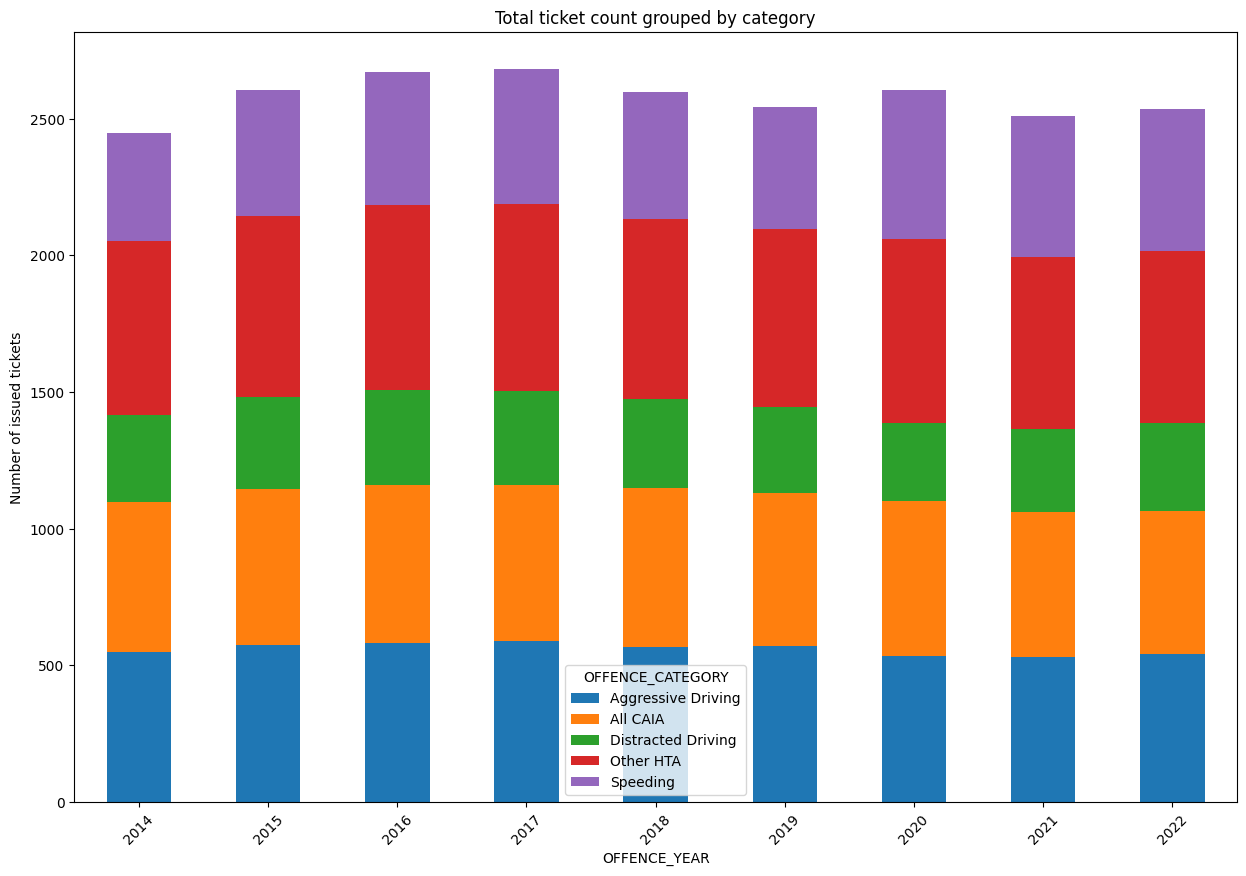

In [ ]:
tickets_crosstab.plot(kind='bar', stacked=True, figsize=(15,10), rot=45);
plt.ylabel('Number of issued tickets')
plt.title('Total ticket count grouped by category');

In [ ]:
tickets_age_crosstab=pd.crosstab(tickets['OFFENCE_YEAR'], tickets['AGE_GROUP'])
tickets_age_crosstab

AGE_GROUP,Adult,Youth
OFFENCE_YEAR,,
2014,1937,511
2015,2072,533
2016,2126,547
2017,2131,553
2018,2076,523
2019,2062,480
2020,2092,515
2021,2080,429
2022,2097,440


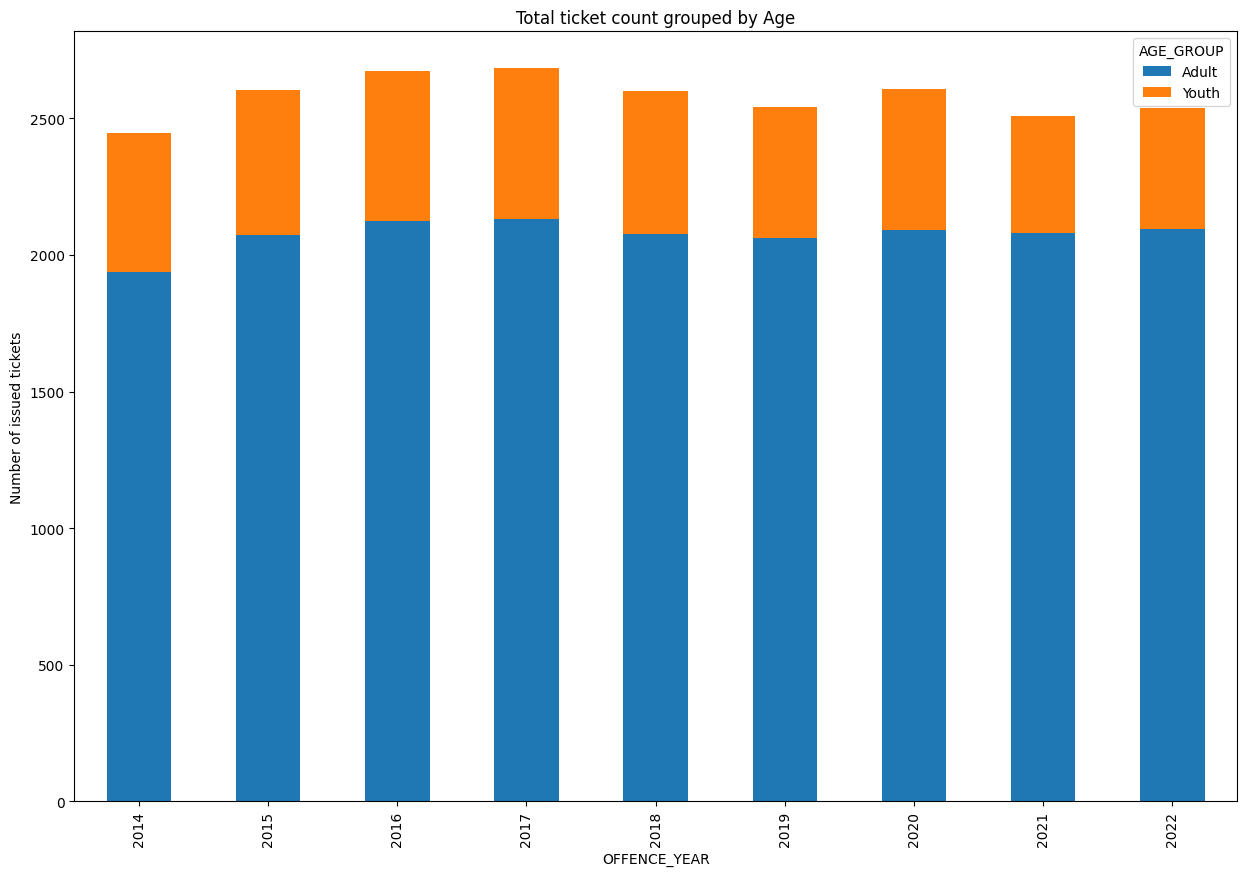

In [ ]:
tickets_age_crosstab.plot(kind='bar', stacked=True, figsize=(15,10))
plt.title('Total ticket count grouped by Age')
plt.ylabel('Number of issued tickets');

##Time analysis: Arrested_charged DataFrame




In [ ]:
arrested_charged.head()

,_id,ARREST_YEAR,DIVISION,HOOD_158,NEIGHBOURHOOD_158,SEX,AGE_COHORT,AGE_GROUP,CATEGORY,SUBTYPE,ARREST_COUNT,SEX_BOOLEAN,CATEGORY_NUMERIC,AGE_GROUP_BOOLEAN,HOOD_158_ENCODED,CATEGORY_ENCODED,AGE_GROUP_ENCODED
0,1,2019,D14,83,Dufferin Grove (83),Female,25 to 34,Adult,Other Criminal Code Violations,Other,1,False,4,True,141,4,1
1,2,2022,D12,30,Brookhaven-Amesbury (30),Male,<18,Youth,Crimes Against the Person,Assaults,2,True,2,False,89,2,0
2,3,2018,D14,165,Harbourfront-CityPlace (165),Male,18 to 24,Adult,Other Criminal Code Violations,Other,1,True,4,True,66,4,1
3,4,2015,D22,18,New Toronto (18),Male,25 to 34,Adult,Controlled Drugs and Substances Act,Other,3,True,0,True,76,0,1
4,5,2014,D52,78,Kensington-Chinatown (78),Male,25 to 34,Adult,Other Criminal Code Violations,Other,46,True,4,True,136,4,1


In [ ]:
AC_groupby_year=arrested_charged.groupby('ARREST_YEAR')[['ARREST_COUNT']].count()
AC_groupby_year

,ARREST_COUNT
ARREST_YEAR,
2014,15484
2015,15138
2016,15609
2017,15350
2018,14620
2019,13658
2020,12782
2021,12912
2022,13821


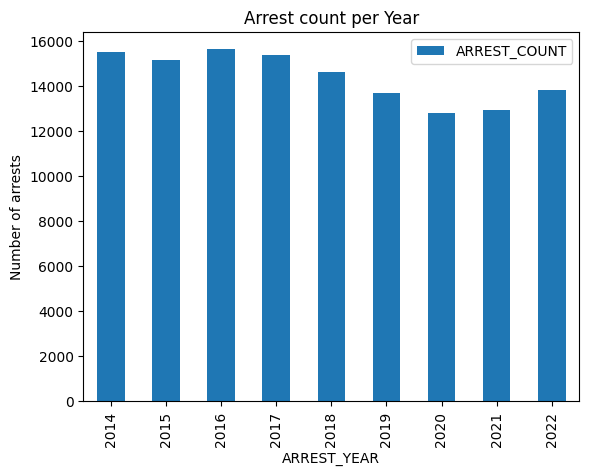

In [ ]:
AC_groupby_year.plot(kind='bar')
plt.title('Arrest count per Year')
plt.ylabel('Number of arrests');

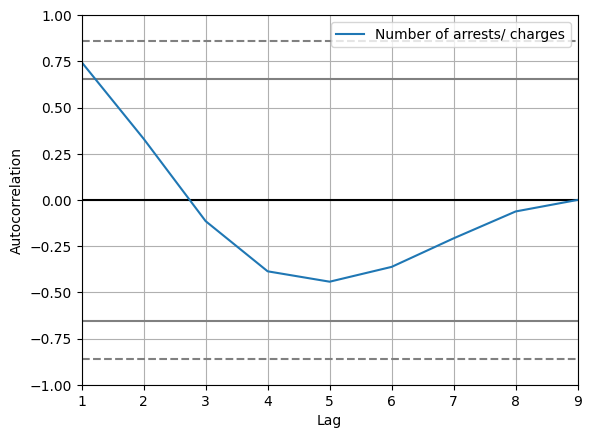

In [ ]:
pd.plotting.autocorrelation_plot(AC_groupby_year['ARREST_COUNT'], label='Number of arrests/ charges');

In [ ]:
corr_arrested = AC_groupby_year['ARREST_COUNT'].corr(arrested_charged['ARREST_YEAR'])
corr_arrested

0.21946002609664889

The weak correlation coefficient for the Number of arrests vs. Year indicates that there isn't strong correlation between the two features.

In [ ]:
AC_groupby_year_div=arrested_charged.groupby(['ARREST_YEAR','DIVISION'])[['_id']].count().reset_index()
AC_groupby_year_div.rename(columns={'_id': 'COUNT'}, inplace=True)
AC_groupby_year_div=AC_groupby_year_div[AC_groupby_year_div['DIVISION']!='NSA']
AC_groupby_year_div

,ARREST_YEAR,DIVISION,COUNT
0,2014,D11,935
1,2014,D12,871
2,2014,D13,776
3,2014,D14,1079
4,2014,D22,1023
...,...,...,...
147,2022,D43,980
148,2022,D51,819
149,2022,D52,674
150,2022,D53,818


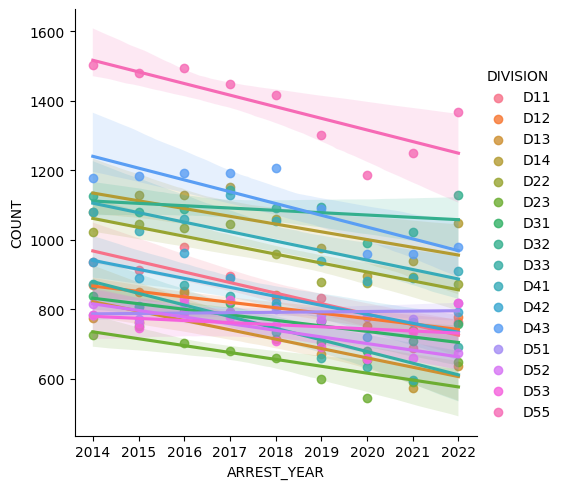

In [ ]:
sns.lmplot(AC_groupby_year_div,x='ARREST_YEAR', y='COUNT', hue='DIVISION')

The category 'Total Arrests' doesn't seem to be a type of category of a crime and does not show up in the other DataFrames. The plot will be analyzed without this category.

In [ ]:
AC_filtered_category=arrested_charged[arrested_charged['CATEGORY'] != 'Total Arrests']

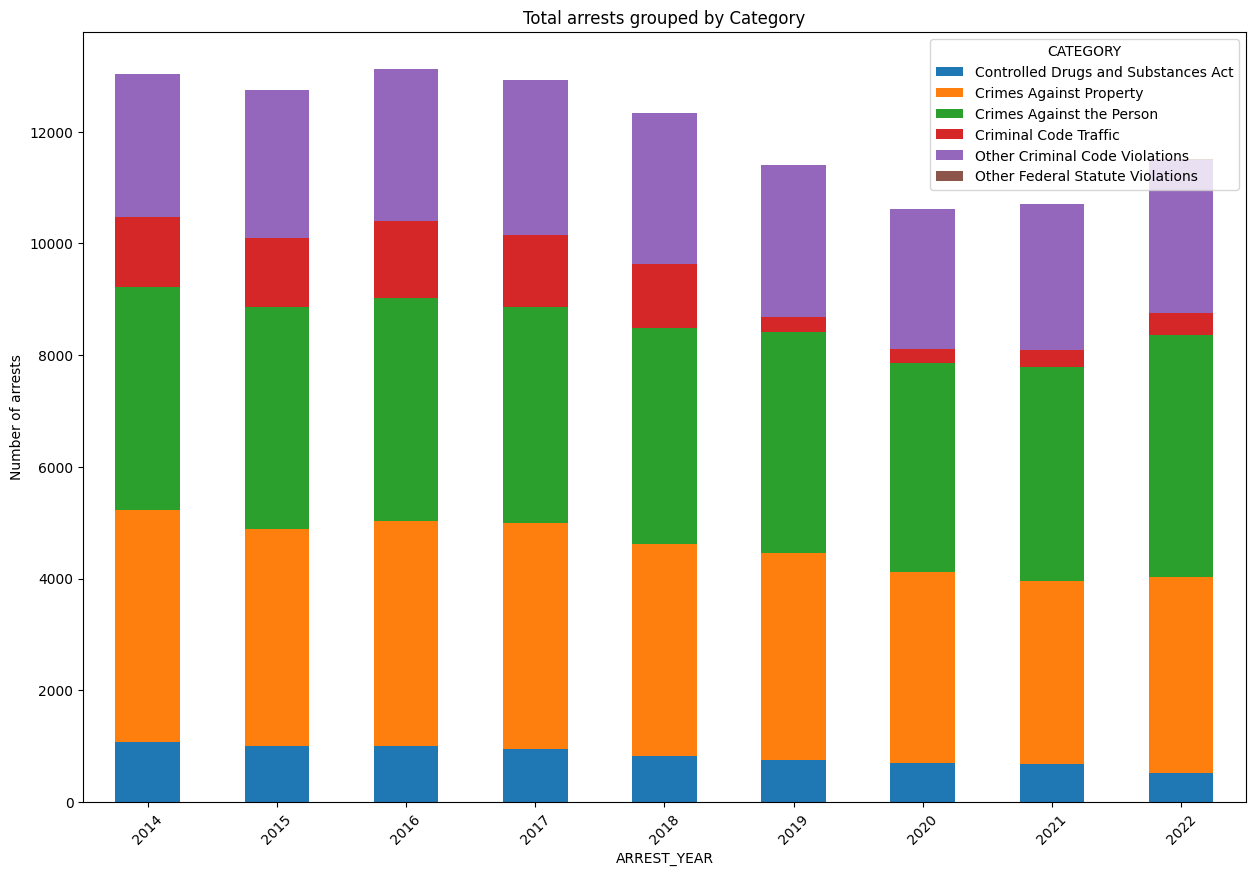

In [ ]:
AC_crosstab_cat=pd.crosstab(AC_filtered_category['ARREST_YEAR'], AC_filtered_category['CATEGORY'])
AC_crosstab_cat.plot(kind='bar', stacked=True, figsize=(15,10), rot=45)
plt.title('Total arrests grouped by Category')
plt.ylabel('Number of arrests');

##Time analysis: Discharged DataFrame

In [ ]:
discharges.head()

,_id,EVENT_UNIQUE_ID,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DOW,OCC_DOY,OCC_DAY,OCC_HOUR,OCC_TIME_RANGE,DIVISION,DEATH,INJURIES,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,geometry
0,1,GO-2004133803,NaN,2004,January,Thursday,1,1,0,Night,D31,0,1,23,Pelmo Park-Humberlea,23,Pelmo Park-Humberlea (23),"{'type': 'MultiPoint', 'coordinates': [[-79.53..."
1,2,GO-2004120070,1073-10-06,2004,January,Saturday,3,3,1,Night,D54,0,0,NSA,NSA,NSA,NSA,"{'type': 'MultiPoint', 'coordinates': [[5.6843..."
2,3,GO-2004135509,NaN,2004,January,Sunday,4,4,4,Night,D14,0,2,78,Kensington-Chinatown,78,Kensington-Chinatown (78),"{'type': 'MultiPoint', 'coordinates': [[-79.39..."
3,4,GO-2004126451,NaN,2004,January,Monday,5,5,13,Afternoon,D41,0,1,124,Kennedy Park,124,Kennedy Park (124),"{'type': 'MultiPoint', 'coordinates': [[-79.25..."
4,5,GO-2004136310,NaN,2004,January,Tuesday,6,6,19,Evening,D42,0,0,146,Malvern East,132,Malvern (132),"{'type': 'MultiPoint', 'coordinates': [[-79.20..."


First, let's drop the column 'OCC_DATE'. The column has ambigous values and the actual date of the discharge can be extracted from the other columns.

In [ ]:
discharges.drop('OCC_DATE', axis=1, inplace=True)

In the previous DataFrames analysis was done on the period from 2014-2022. In order to be aligned with the other DataFrames and the analysis to be compared among one another, we'll take a portion of this DataFrame that corresponds to the period 2014-2022.

In [ ]:
discharges_section=discharges.loc[2274:5707]

In this dataset there is multiple columns containing information on the time of the discharge.
First, let's group the DataFrame by year:

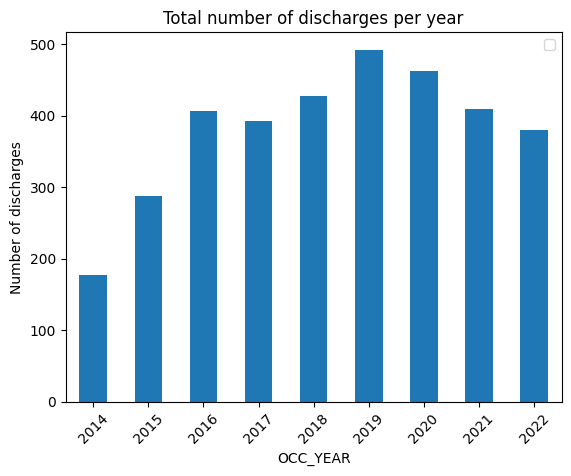

In [ ]:
discharges_year_count=discharges_section.groupby('OCC_YEAR')[['_id']].count().reset_index()
discharges_year_count.plot(kind='bar',x='OCC_YEAR',y=['_id'], rot=45)
plt.title('Total number of discharges per year')
plt.ylabel('Number of discharges');

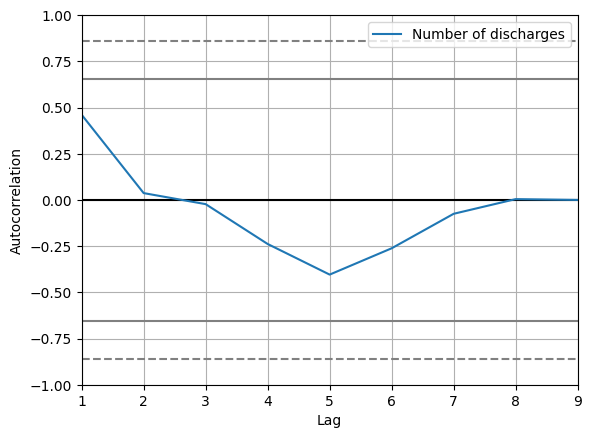

In [ ]:
ACPlot=pd.plotting.autocorrelation_plot(discharges_year_count['_id'], label='Number of discharges');

In [ ]:
corr_discharges = discharges_year_count['_id'].corr(discharges_year_count['OCC_YEAR'])
corr_discharges

0.6624949238186978

There is a positive correlation coefficient, indicating that as the time progresses the number of discharges tends to increase.

In [ ]:
discharges_year_death_injuries=discharges_section.groupby('OCC_YEAR')[['DEATH','INJURIES']].sum()
discharges_year_death_injuries

,DEATH,INJURIES
OCC_YEAR,,
2014,27,76
2015,26,126
2016,41,152
2017,39,148
2018,51,178
2019,44,240
2020,39,178
2021,46,163
2022,44,150


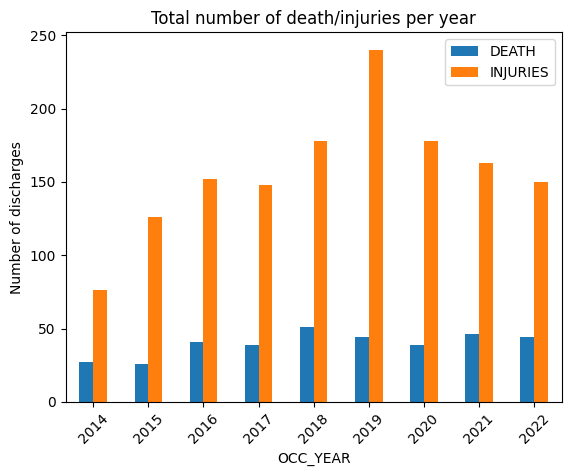

In [ ]:
discharges_year_death_injuries.plot(kind='bar', rot=45)
plt.title('Total number of death/injuries per year')
plt.ylabel('Number of discharges');

Next, let's do the same analysis on the DataFrame grouped by month:

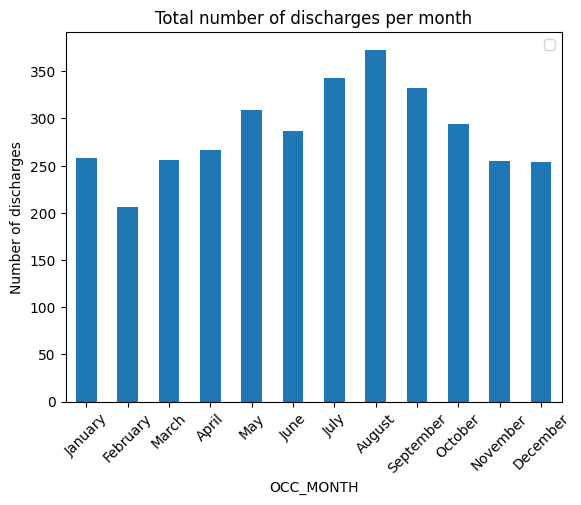

In [ ]:
discharges_month_count=discharges_section.groupby('OCC_MONTH')[['_id']].count()

#Setting a month order
month_order=['January','February','March','April','May','June','July','August','September','October','November','December']

#Rearranging the DF
discharges_month_count=discharges_month_count.reindex(month_order)

#Plotting the outcome
discharges_month_count.plot(kind='bar',rot=45)
plt.title('Total number of discharges per month')
plt.ylabel('Number of discharges');

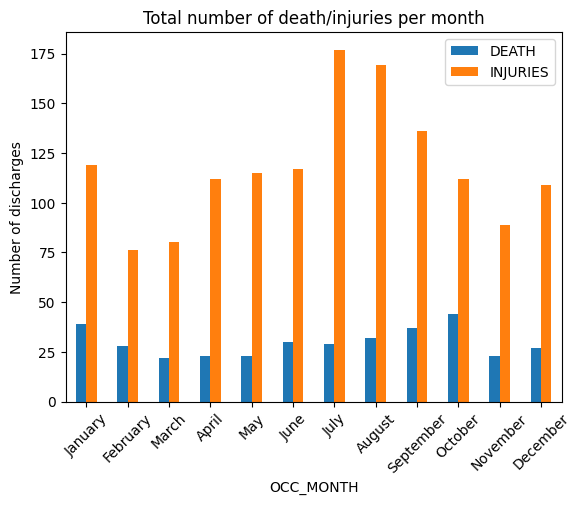

In [ ]:
discharges_month_death_injuries=discharges_section.groupby('OCC_MONTH')[['DEATH','INJURIES']].sum()
discharges_month_death_injuries=discharges_month_death_injuries.reindex(month_order)
discharges_month_death_injuries.plot(kind='bar',rot=45)
plt.title('Total number of death/injuries per month')
plt.ylabel('Number of discharges');

Grouped by day of the week:

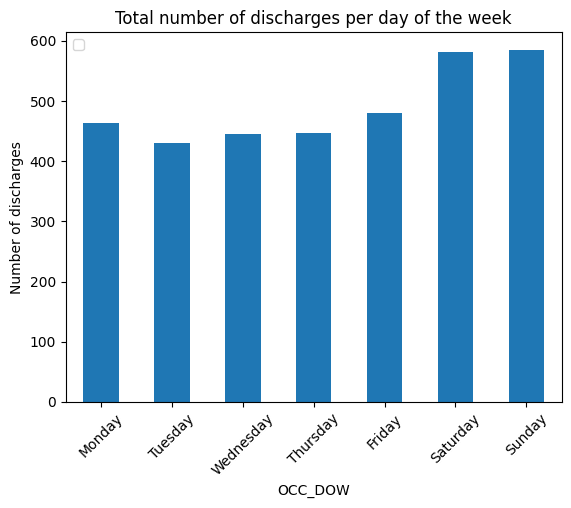

In [ ]:
discharges_dow_count=discharges_section.groupby('OCC_DOW')[['_id']].count()

dow_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

discharges_dow_count=discharges_dow_count.reindex(dow_order)

discharges_dow_count.plot(kind='bar',rot=45)
plt.title('Total number of discharges per day of the week')
plt.ylabel('Number of discharges');

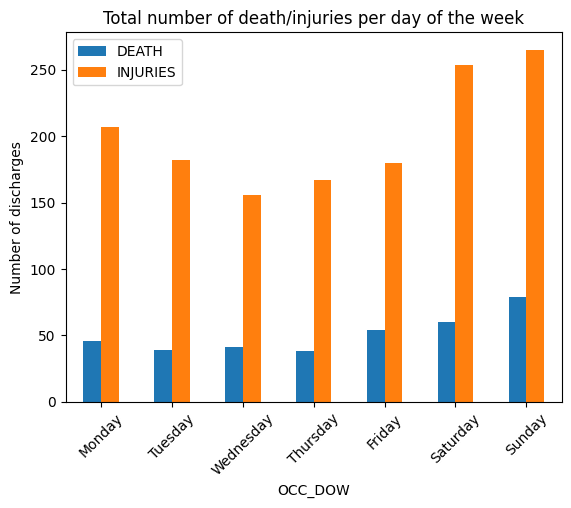

In [ ]:
discharges_dow_DI=discharges_section.groupby('OCC_DOW')[['DEATH','INJURIES']].sum()

discharges_dow_DI=discharges_dow_DI.reindex(dow_order)

discharges_dow_DI.plot(kind='bar',rot=45)
plt.title('Total number of death/injuries per day of the week')
plt.ylabel('Number of discharges');

Lastly, grouped by period of the day:

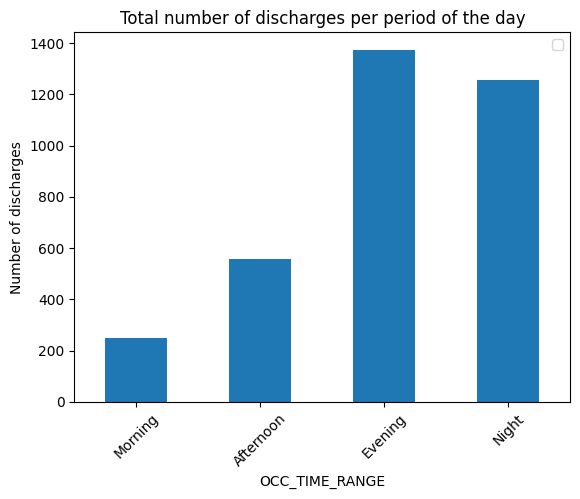

In [ ]:
discharges_range_count=discharges_section.groupby('OCC_TIME_RANGE')[['_id']].count()

period_order = ['Morning', 'Afternoon', 'Evening', 'Night']

discharges_range_count=discharges_range_count.reindex(period_order)

discharges_range_count.plot(kind='bar',rot=45)
plt.title('Total number of discharges per period of the day')
plt.ylabel('Number of discharges');

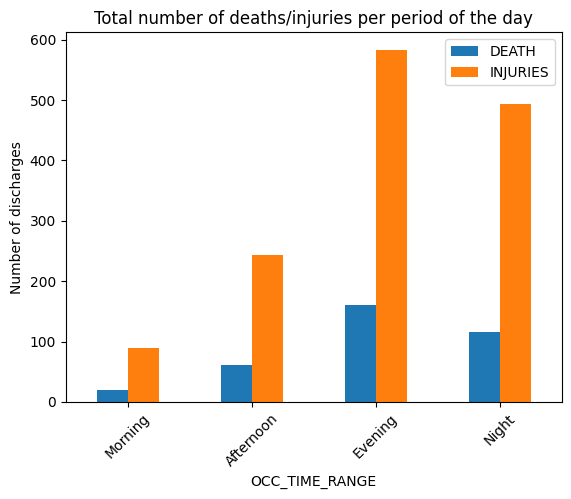

In [ ]:
discharges_range_DI=discharges_section.groupby('OCC_TIME_RANGE')[['DEATH','INJURIES']].sum()

discharges_range_DI=discharges_range_DI.reindex(period_order)

discharges_range_DI.plot(kind='bar',rot=45)
plt.title('Total number of deaths/injuries per period of the day')
plt.ylabel('Number of discharges');


## Summary

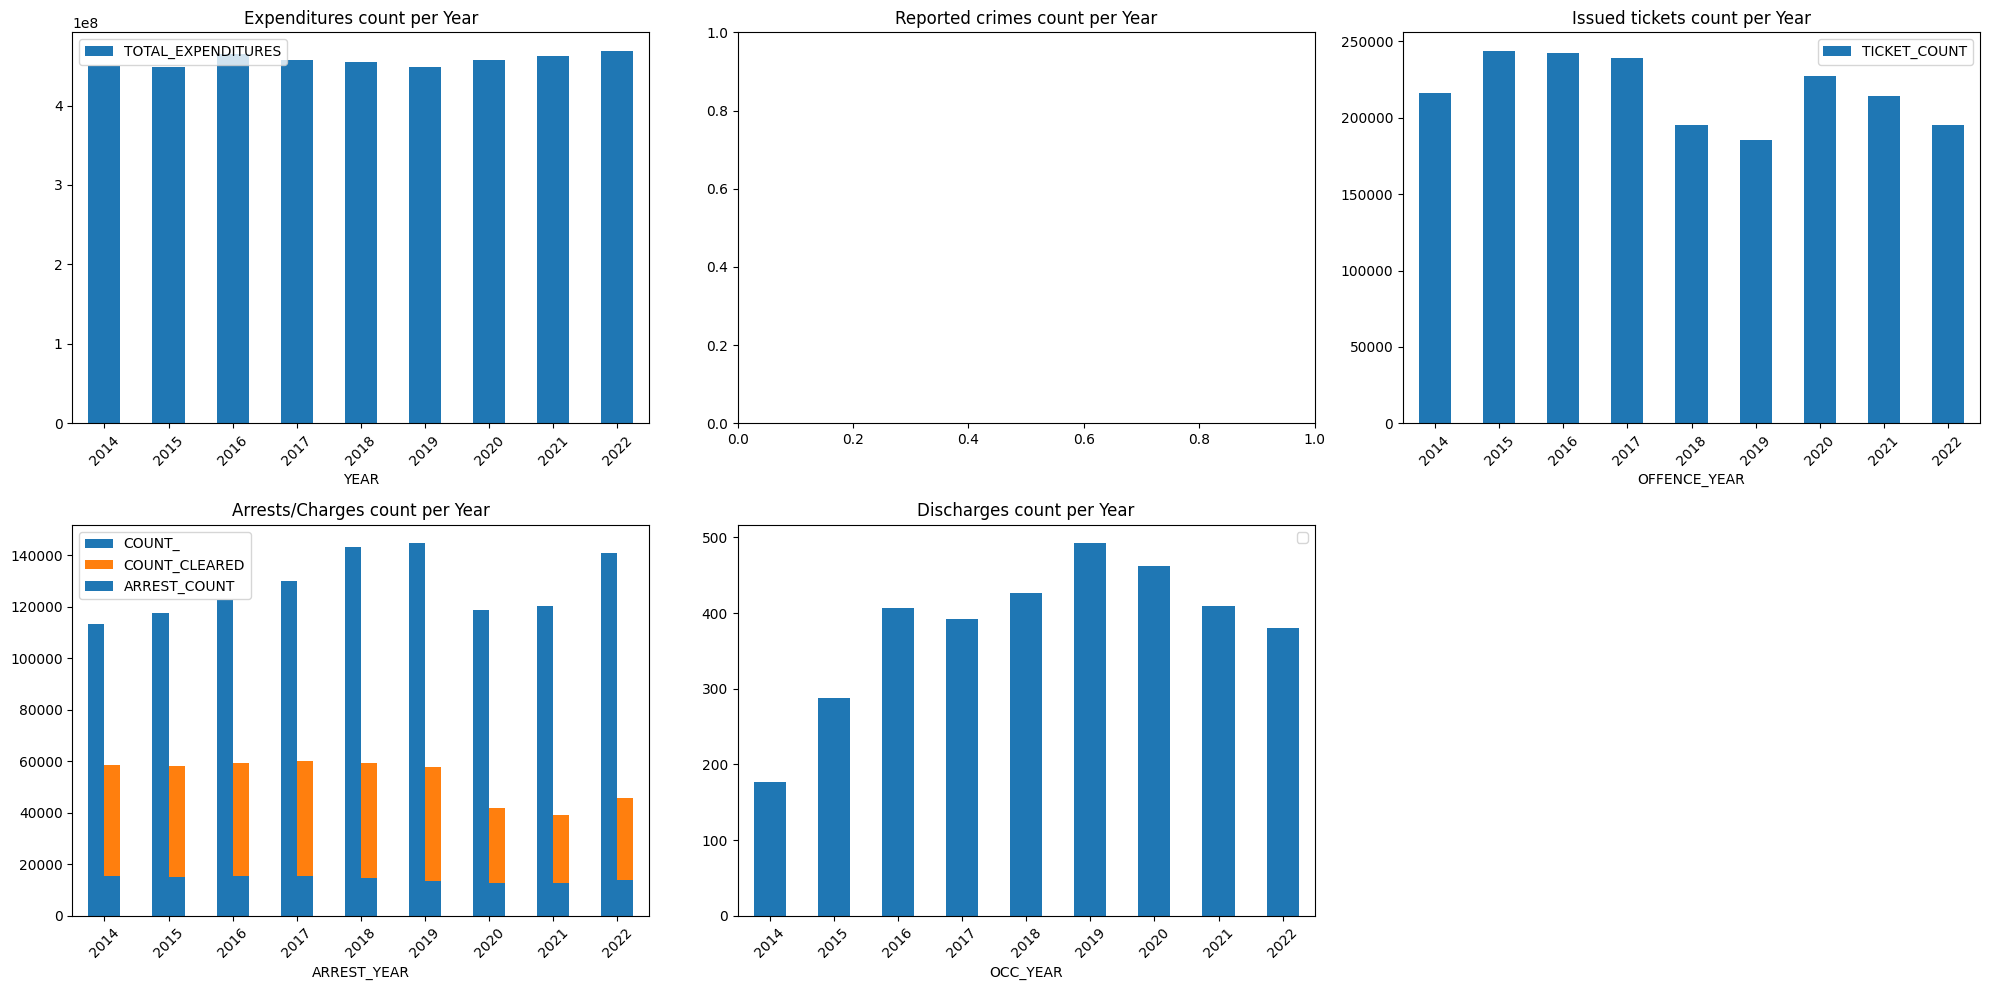

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

total_expenditures.plot(kind='bar', x='YEAR', y=['TOTAL_EXPENDITURES'],rot=45, ax=axes[0,0])
rc_groupby_year.plot(kind='bar', x='REPORT_YEAR', y=['COUNT_','COUNT_CLEARED'],rot=45, ax=axes[1,0])
tickets_groupby_year.plot(kind='bar', x='OFFENCE_YEAR', y='TICKET_COUNT',rot=45, ax=axes[0,2])
AC_groupby_year.plot(kind='bar',rot=45, ax=axes[1,0])
discharges_year_count.plot(kind='bar',x='OCC_YEAR',y=['_id'],rot=45, ax=axes[1,1]);

ax = plt.subplot(2,3,1)
ax.set_title("Expenditures count per Year")
ax = plt.subplot(2,3,2)
ax.set_title("Reported crimes count per Year")
ax = plt.subplot(2,3,3)
ax.set_title("Issued tickets count per Year")
ax = plt.subplot(2,3,4)
ax.set_title("Arrests/Charges count per Year")
ax = plt.subplot(2,3,5)
ax.set_title("Discharges count per Year")

axes[1, 2].axis('off')

plt.tight_layout();

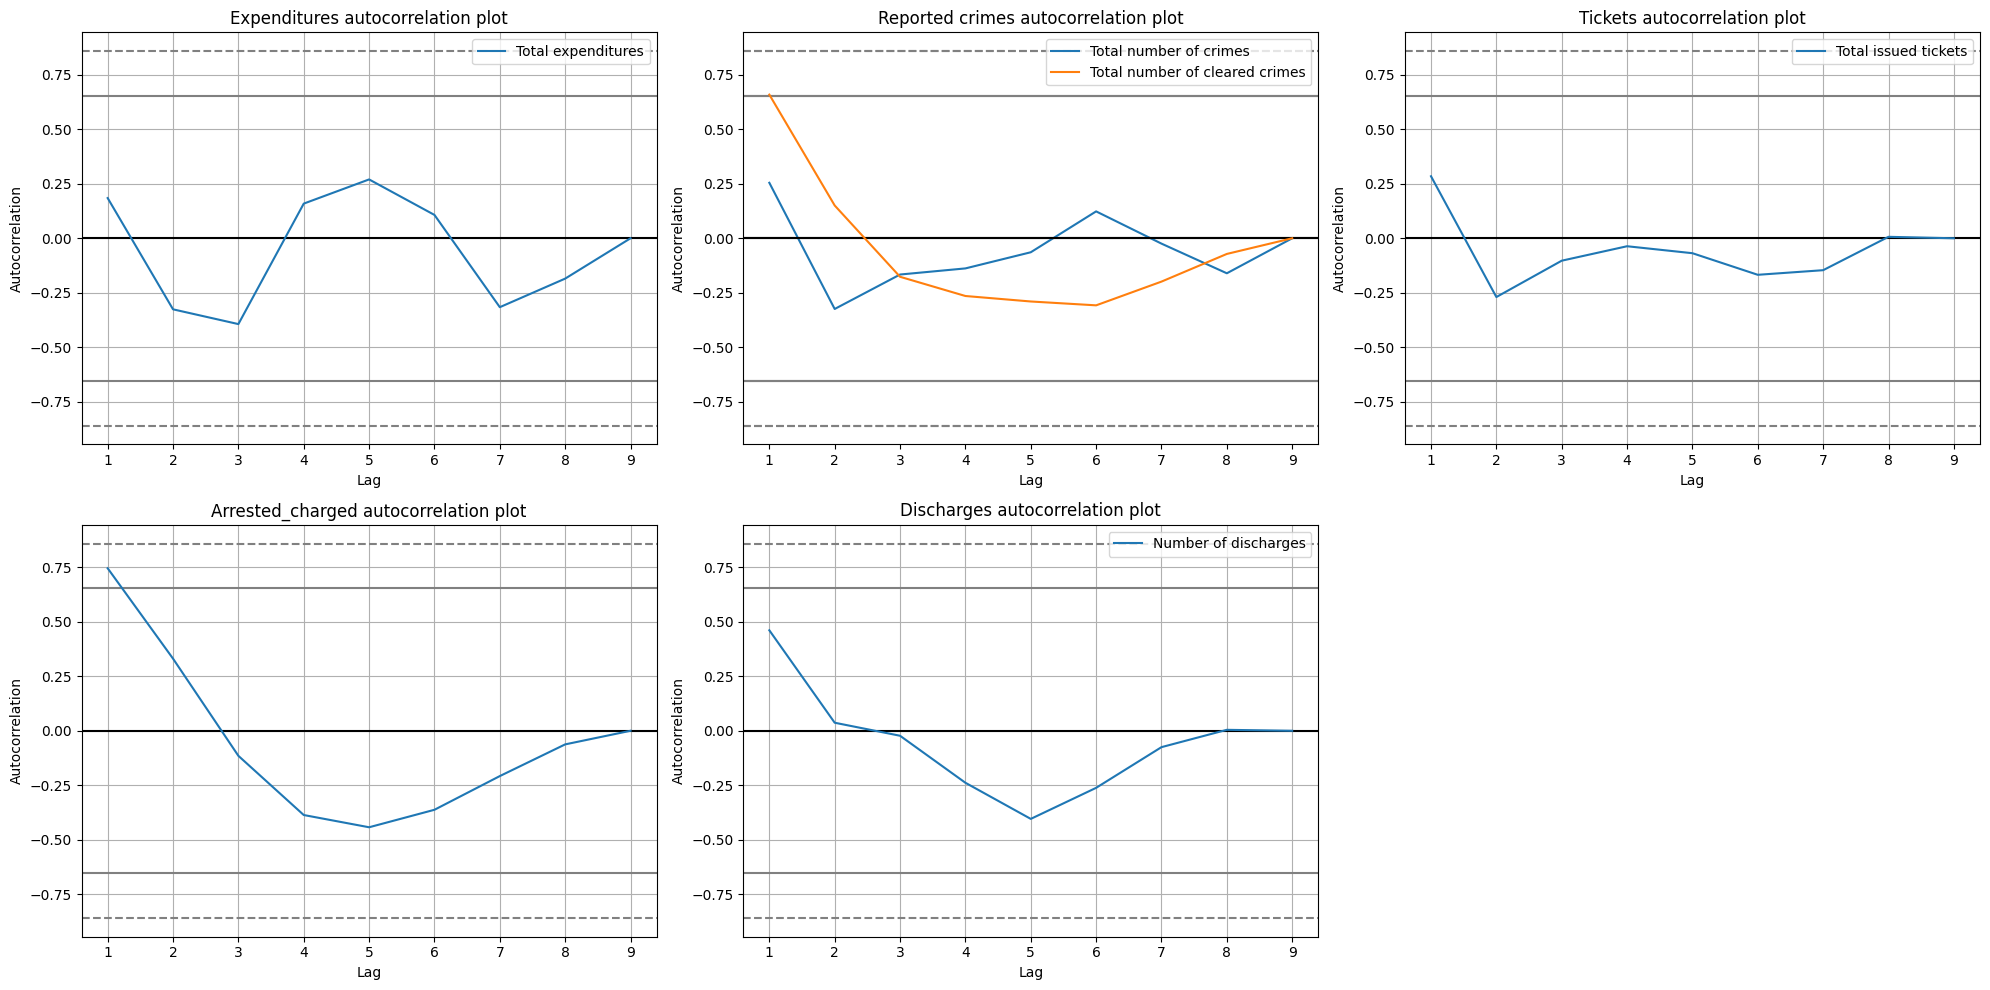

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

pd.plotting.autocorrelation_plot(total_expenditures['TOTAL_EXPENDITURES'], label='Total expenditures',ax=axes[0,0])

pd.plotting.autocorrelation_plot(rc_groupby_year['COUNT_'], label='Total number of crimes',ax=axes[0,1])
ACPlot=pd.plotting.autocorrelation_plot(rc_groupby_year['COUNT_CLEARED'], label='Total number of cleared crimes',ax=axes[0,1])

pd.plotting.autocorrelation_plot(tickets_groupby_year['TICKET_COUNT'], label='Total issued tickets', ax=axes[0,2])

pd.plotting.autocorrelation_plot(AC_groupby_year['ARREST_COUNT'], ax=axes[1,0])

pd.plotting.autocorrelation_plot(discharges_year_count['_id'], label='Number of discharges', ax=axes[1,1]);

ax = plt.subplot(2,3,1)
ax.set_title("Expenditures autocorrelation plot")
ax = plt.subplot(2,3,2)
ax.set_title("Reported crimes autocorrelation plot")
ax = plt.subplot(2,3,3)
ax.set_title("Tickets autocorrelation plot")
ax = plt.subplot(2,3,4)
ax.set_title("Arrested_charged autocorrelation plot")
ax = plt.subplot(2,3,5)
ax.set_title("Discharges autocorrelation plot")

axes[1, 2].axis('off')

plt.tight_layout();

In [ ]:
print('Correlation Coefficients:')
print('Expenditures: ',corr_count_expenditures)
print('Reported Crimes: ',corr_count_rc)
print('Cleared Crimes: ',corr_cleared_rc_cleared)
print('Tickets: ',corr_count_tickets)
print('Arrests: ',corr_arrested)
print('Discharges: ',corr_discharges)

Correlation Coefficients:
Expenditures:  0.5874128359726277
Reported Crimes:  0.4723841719482602
Cleared Crimes:  -0.7875774525396007
Tickets:  -0.5289676587164309
Arrests:  0.21946002609664889
Discharges:  0.6624949238186978


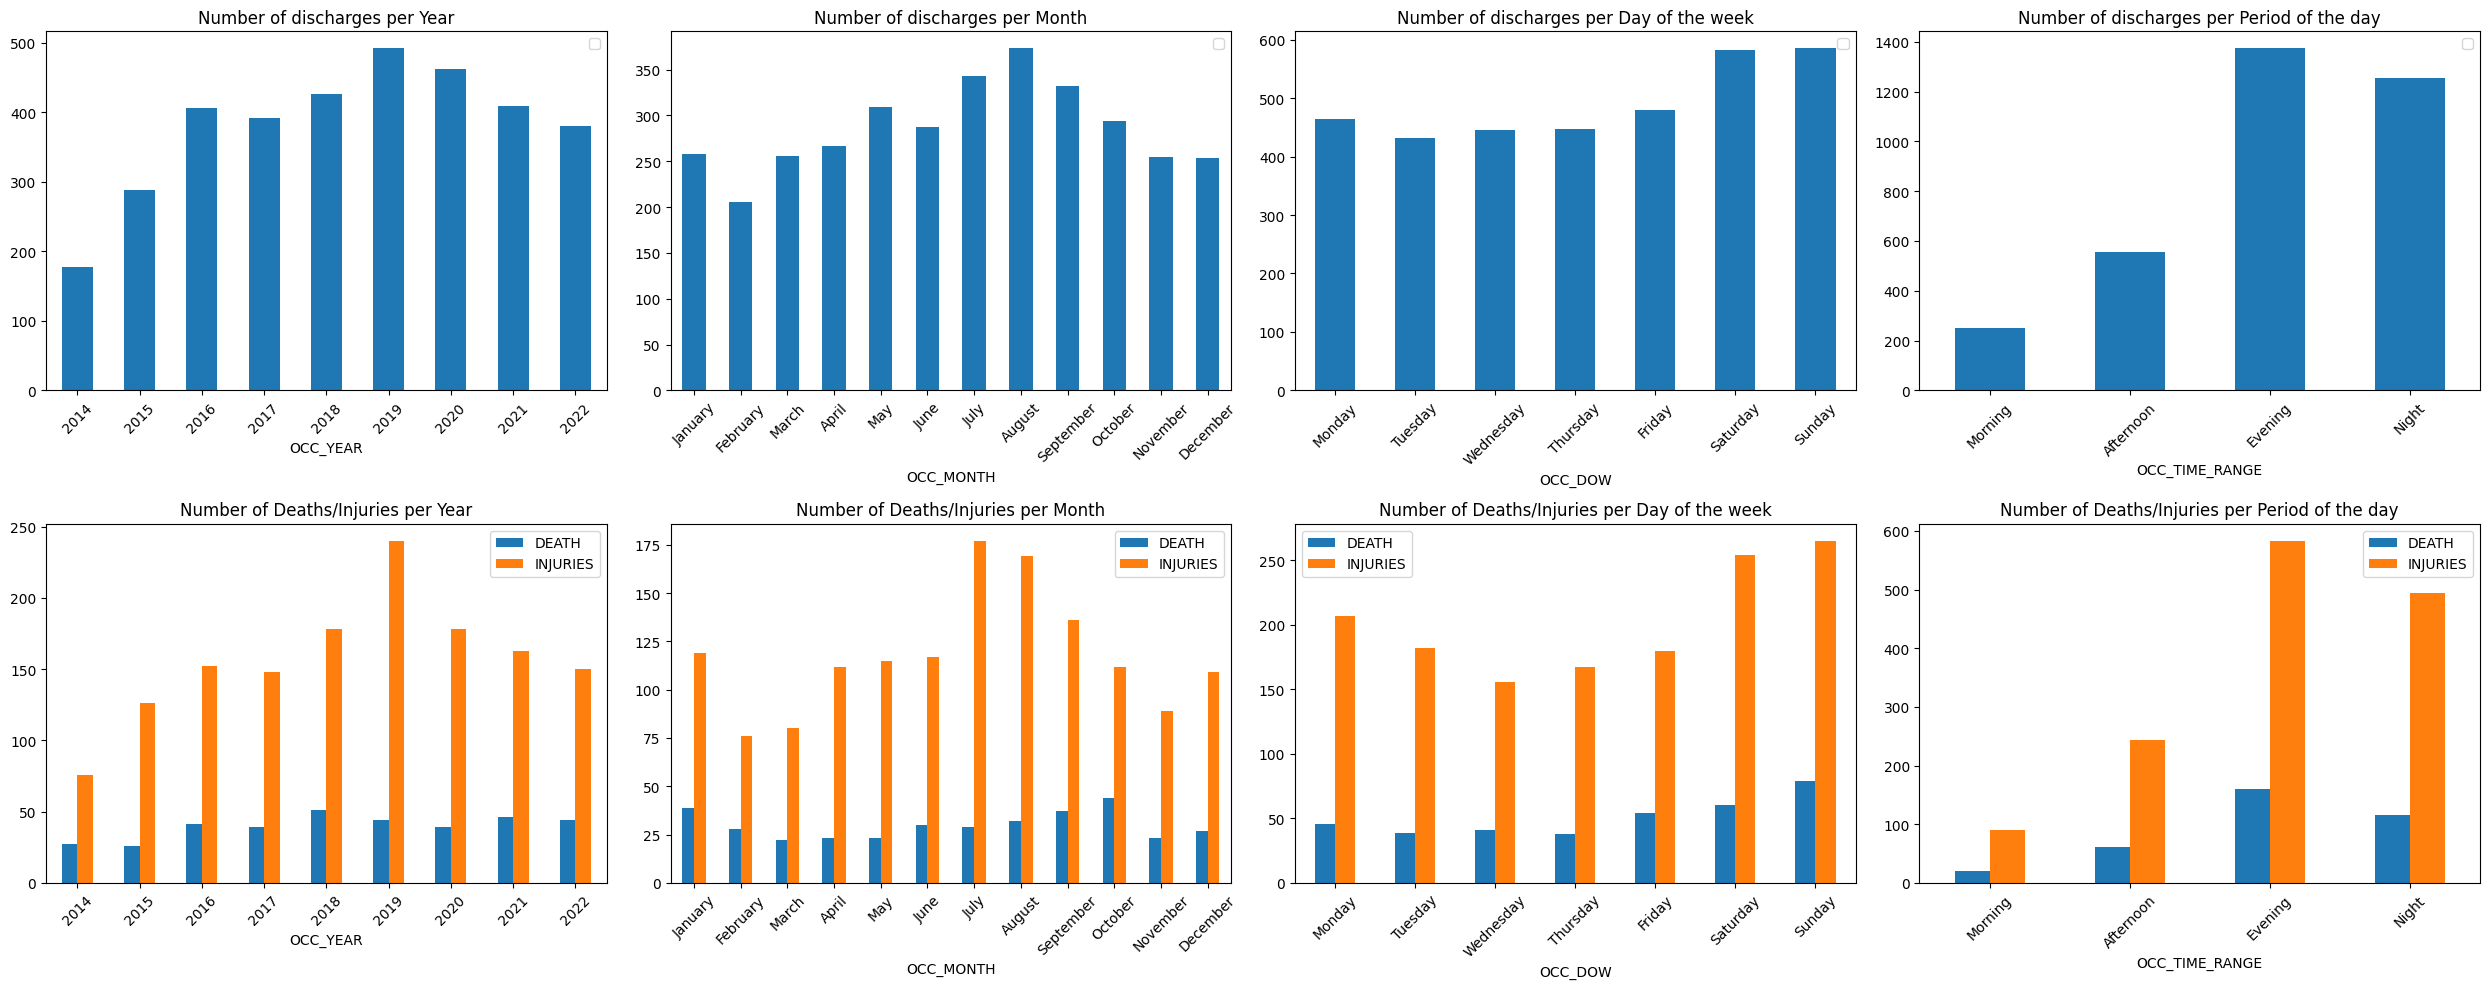

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))

discharges_year_count.plot(kind='bar',x='OCC_YEAR',y=['_id'], rot=45, ax=axes[0,0])
discharges_year_death_injuries.plot(kind='bar', rot=45, ax=axes[1,0])
discharges_month_count.plot(kind='bar',rot=45, ax=axes[0,1])
discharges_month_death_injuries.plot(kind='bar',rot=45, ax=axes[1,1])
discharges_dow_count.plot(kind='bar',rot=45, ax=axes[0,2])
discharges_dow_DI.plot(kind='bar',rot=45, ax=axes[1,2])
discharges_range_count.plot(kind='bar',rot=45, ax=axes[0,3])
discharges_range_DI.plot(kind='bar',rot=45, ax=axes[1,3]);


ax = plt.subplot(2,4,1)
ax.set_title("Number of discharges per Year")
ax = plt.subplot(2,4,2)
ax.set_title("Number of discharges per Month")
ax = plt.subplot(2,4,3)
ax.set_title("Number of discharges per Day of the week")
ax = plt.subplot(2,4,4)
ax.set_title("Number of discharges per Period of the day")
ax = plt.subplot(2,4,5)
ax.set_title("Number of Deaths/Injuries per Year")
ax = plt.subplot(2,4,6)
ax.set_title("Number of Deaths/Injuries per Month")
ax = plt.subplot(2,4,7)
ax.set_title("Number of Deaths/Injuries per Day of the week")
ax = plt.subplot(2,4,8)
ax.set_title("Number of Deaths/Injuries per Period of the day")

plt.tight_layout();

#Attribute Analysis

In [ ]:
grouped_arrest_count= arrested_charged.groupby(['DIVISION'])['ARREST_COUNT'].sum().reset_index(name='Total_Arrest_Count')
print(grouped_arrest_count)


   DIVISION  Total_Arrest_Count
0       D11               29945
1       D12               27626
2       D13               20085
3       D14               44866
4       D22               34037
5       D23               26890
6       D31               37906
7       D32               36506
8       D33               20399
9       D41               49014
10      D42               26670
11      D43               51607
12      D51               58501
13      D52               57069
14      D53               22808
15      D55               49301
16      NSA                9469


In [ ]:
grouped_arrest_ageg_count = arrested_charged.groupby(['DIVISION', 'AGE_GROUP']).size().reset_index(name='Total_Arrest_Count')
print(grouped_arrest_ageg_count)


   DIVISION AGE_GROUP  Total_Arrest_Count
0       D11     Adult                6887
1       D11   Unknown                   3
2       D11     Youth                 731
3       D12     Adult                6508
4       D12     Youth                 734
5       D13     Adult                5859
6       D13     Youth                 570
7       D14     Adult                8656
8       D14     Youth                 751
9       D22     Adult                7730
10      D22     Youth                 899
11      D23     Adult                5221
12      D23     Youth                 685
13      D31     Adult                6074
14      D31     Youth                 842
15      D32     Adult                8835
16      D32     Youth                 926
17      D33     Adult                5956
18      D33   Unknown                   2
19      D33     Youth                 753
20      D41     Adult                7848
21      D41   Unknown                   2
22      D41     Youth             

In [ ]:
grouped_arrest_agec_count = arrested_charged.groupby(['DIVISION', 'AGE_COHORT']).size().reset_index(name='Total_Arrest_Count')
print(grouped_arrest_agec_count)

    DIVISION AGE_COHORT  Total_Arrest_Count
0        D11   18 to 24                1365
1        D11   25 to 34                1696
2        D11   35 to 44                1457
3        D11   45 to 54                1240
4        D11   55 to 64                 790
..       ...        ...                 ...
118      NSA   35 to 44                 238
119      NSA   45 to 54                 180
120      NSA   55 to 64                 118
121      NSA        65+                  46
122      NSA        <18                 134

[123 rows x 3 columns]


In [ ]:
grouped_arrest_sex_count = arrested_charged.groupby(['DIVISION', 'SEX']).size().reset_index(name='Total_Arrest_Count')
print(grouped_arrest_sex_count)

   DIVISION     SEX  Total_Arrest_Count
0       D11  Female                2319
1       D11    Male                5302
2       D12  Female                2154
3       D12    Male                5088
4       D13  Female                1757
5       D13    Male                4672
6       D14  Female                2883
7       D14    Male                6524
8       D22  Female                2391
9       D22    Male                6238
10      D23  Female                1590
11      D23    Male                4316
12      D31  Female                2099
13      D31    Male                4817
14      D32  Female                2544
15      D32    Male                7217
16      D33  Female                1867
17      D33    Male                4844
18      D41  Female                2844
19      D41    Male                6122
20      D42  Female                2062
21      D42    Male                5475
22      D43  Female                3116
23      D43    Male                6823


In [ ]:
grouped_arrest_cat_count = arrested_charged.groupby(['DIVISION', 'CATEGORY']).size().reset_index(name='Total_Arrest_Count')
print(grouped_arrest_cat_count)

    DIVISION                             CATEGORY  Total_Arrest_Count
0        D11  Controlled Drugs and Substances Act                 479
1        D11              Crimes Against Property                2087
2        D11            Crimes Against the Person                1945
3        D11                Criminal Code Traffic                 389
4        D11       Other Criminal Code Violations                1438
..       ...                                  ...                 ...
111      NSA            Crimes Against the Person                 274
112      NSA                Criminal Code Traffic                 153
113      NSA       Other Criminal Code Violations                 282
114      NSA     Other Federal Statute Violations                   1
115      NSA                        Total Arrests                 179

[116 rows x 3 columns]


In [ ]:
grouped_arrest_hood_count = arrested_charged.groupby(['DIVISION', 'HOOD_158']).size().reset_index(name='Total_Arrest_Count')
print(grouped_arrest_hood_count)

    DIVISION HOOD_158  Total_Arrest_Count
0        D11      111                 298
1        D11      113                   2
2        D11      114                 373
3        D11       13                   3
4        D11      159                   2
..       ...      ...                 ...
389      NSA       64                   5
390      NSA       70                   3
391      NSA       73                   2
392      NSA       74                   9
393      NSA      NSA                1147

[394 rows x 3 columns]


In [ ]:
grouped_arrest_year_count = arrested_charged.groupby(['DIVISION', 'ARREST_YEAR']).size().reset_index(name='Total_Arrest_Count')
print(grouped_arrest_year_count)

    DIVISION  ARREST_YEAR  Total_Arrest_Count
0        D11         2014                 935
1        D11         2015                 913
2        D11         2016                 978
3        D11         2017                 897
4        D11         2018                 833
..       ...          ...                 ...
148      NSA         2018                 155
149      NSA         2019                 127
150      NSA         2020                 130
151      NSA         2021                 129
152      NSA         2022                 133

[153 rows x 3 columns]


In [ ]:
grouped_arrest_ageg_count = arrested_charged.groupby(['DIVISION', 'AGE_GROUP']).size().reset_index(name='Total_Arrest_Count')
total_arrest_count_per_division = grouped_arrest_ageg_count.groupby('DIVISION')['Total_Arrest_Count'].sum()
grouped_arrest_ageg_count['Percentage'] = grouped_arrest_ageg_count.apply(lambda row: (row['Total_Arrest_Count'] / total_arrest_count_per_division[row['DIVISION']]) * 100, axis=1)
print(grouped_arrest_ageg_count)

   DIVISION AGE_GROUP  Total_Arrest_Count  Percentage
0       D11     Adult                6887   90.368718
1       D11   Unknown                   3    0.039365
2       D11     Youth                 731    9.591917
3       D12     Adult                6508   89.864678
4       D12     Youth                 734   10.135322
5       D13     Adult                5859   91.133924
6       D13     Youth                 570    8.866076
7       D14     Adult                8656   92.016583
8       D14     Youth                 751    7.983417
9       D22     Adult                7730   89.581643
10      D22     Youth                 899   10.418357
11      D23     Adult                5221   88.401625
12      D23     Youth                 685   11.598375
13      D31     Adult                6074   87.825333
14      D31     Youth                 842   12.174667
15      D32     Adult                8835   90.513267
16      D32     Youth                 926    9.486733
17      D33     Adult       

In [ ]:
grouped_arrest_agec_count = arrested_charged.groupby(['DIVISION', 'AGE_COHORT']).size().reset_index(name='Total_Arrest_Count')
total_arrest_count_per_division = grouped_arrest_agec_count.groupby('DIVISION')['Total_Arrest_Count'].sum()
grouped_arrest_agec_count['Percentage'] = grouped_arrest_agec_count.apply(lambda row: (row['Total_Arrest_Count'] / total_arrest_count_per_division[row['DIVISION']]) * 100, axis=1)
print(grouped_arrest_agec_count)

    DIVISION AGE_COHORT  Total_Arrest_Count  Percentage
0        D11   18 to 24                1365   17.911035
1        D11   25 to 34                1696   22.254297
2        D11   35 to 44                1457   19.118226
3        D11   45 to 54                1240   16.270831
4        D11   55 to 64                 790   10.366094
..       ...        ...                 ...         ...
118      NSA   35 to 44                 238   18.550273
119      NSA   45 to 54                 180   14.029618
120      NSA   55 to 64                 118    9.197194
121      NSA        65+                  46    3.585347
122      NSA        <18                 134   10.444271

[123 rows x 4 columns]


In [ ]:
grouped_arrest_agec1_count = arrested_charged.groupby(['DIVISION', 'AGE_COHORT']).size().reset_index(name='Total_Arrest_Count')

total_arrest_count_per_division = grouped_arrest_agec_count.groupby('DIVISION')['Total_Arrest_Count'].sum()
grouped_arrest_agec1_count['Percentage'] = grouped_arrest_sex_count.apply(lambda row: (row['Total_Arrest_Count'] / total_arrest_count_per_division[row['DIVISION']]) * 100, axis=1)
average_25_34_arrest_percentage = grouped_arrest_agec1_count[grouped_arrest_agec1_count['AGE_COHORT'] == '25 to 34']['Percentage'].mean()
print("Average 25 to 34 Arrest Percentage Across All Divisions:", average_25_34_arrest_percentage)

Average 25 to 34 Arrest Percentage Across All Divisions: 53.80182715847908


In [ ]:
grouped_arrest_agec2_count = arrested_charged.groupby(['DIVISION', 'AGE_COHORT']).size().reset_index(name='Total_Arrest_Count')

total_arrest_count_per_division = grouped_arrest_agec_count.groupby('DIVISION')['Total_Arrest_Count'].sum()
grouped_arrest_agec2_count['Percentage'] = grouped_arrest_agec2_count.apply(lambda row: (row['Total_Arrest_Count'] / total_arrest_count_per_division[row['DIVISION']]) * 100, axis=1)
average_65_arrest_percentage = grouped_arrest_agec2_count[grouped_arrest_agec_count['AGE_COHORT'] == '<18']['Percentage'].mean()
print("Average of Minors Arrest Percentage Across All Divisions:", average_65_arrest_percentage)

Average of Minors Arrest Percentage Across All Divisions: 10.562015861839926


In [ ]:
grouped_arrest_agec3_count = arrested_charged.groupby(['DIVISION', 'AGE_COHORT']).size().reset_index(name='Total_Arrest_Count')

total_arrest_count_per_division = grouped_arrest_agec_count.groupby('DIVISION')['Total_Arrest_Count'].sum()
grouped_arrest_agec3_count['Percentage'] = grouped_arrest_agec3_count.apply(lambda row: (row['Total_Arrest_Count'] / total_arrest_count_per_division[row['DIVISION']]) * 100, axis=1)
average_65_arrest_percentage = grouped_arrest_agec3_count[grouped_arrest_agec_count['AGE_COHORT'] == '65+']['Percentage'].mean()
print("Average of Seniors Arrest Percentage Across All Divisions:", average_65_arrest_percentage)

Average of Seniors Arrest Percentage Across All Divisions: 4.027347338616814


In [ ]:
grouped_arrest_sex_count = arrested_charged.groupby(['DIVISION', 'SEX']).size().reset_index(name='Total_Arrest_Count')
total_arrest_count_per_division = grouped_arrest_agec_count.groupby('DIVISION')['Total_Arrest_Count'].sum()
grouped_arrest_sex_count['Percentage'] = grouped_arrest_sex_count.apply(lambda row: (row['Total_Arrest_Count'] / total_arrest_count_per_division[row['DIVISION']]) * 100, axis=1)
print(grouped_arrest_sex_count)

   DIVISION     SEX  Total_Arrest_Count  Percentage
0       D11  Female                2319   30.429078
1       D11    Male                5302   69.570922
2       D12  Female                2154   29.743165
3       D12    Male                5088   70.256835
4       D13  Female                1757   27.329289
5       D13    Male                4672   72.670711
6       D14  Female                2883   30.647390
7       D14    Male                6524   69.352610
8       D22  Female                2391   27.708889
9       D22    Male                6238   72.291111
10      D23  Female                1590   26.921774
11      D23    Male                4316   73.078226
12      D31  Female                2099   30.349913
13      D31    Male                4817   69.650087
14      D32  Female                2544   26.062903
15      D32    Male                7217   73.937097
16      D33  Female                1867   27.819997
17      D33    Male                4844   72.180003
18      D41 

In [ ]:
grouped_arrest_sex_count = arrested_charged.groupby(['DIVISION', 'SEX']).size().reset_index(name='Total_Arrest_Count')

total_arrest_count_per_division = grouped_arrest_sex_count.groupby('DIVISION')['Total_Arrest_Count'].sum()
grouped_arrest_sex_count['Percentage'] = grouped_arrest_sex_count.apply(lambda row: (row['Total_Arrest_Count'] / total_arrest_count_per_division[row['DIVISION']]) * 100, axis=1)
average_male_arrest_percentage = grouped_arrest_sex_count[grouped_arrest_sex_count['SEX'] == 'Male']['Percentage'].mean()
print("Average Male Arrest Percentage Across All Divisions:", average_male_arrest_percentage)


Average Male Arrest Percentage Across All Divisions: 70.48251334828356


In [ ]:
grouped_arrest_cat_count = arrested_charged.groupby(['DIVISION', 'CATEGORY']).size().reset_index(name='Total_Arrest_Count')
total_arrest_count_per_division = grouped_arrest_cat_count.groupby('DIVISION')['Total_Arrest_Count'].sum()
grouped_arrest_cat_count['Percentage'] = grouped_arrest_cat_count.apply(lambda row: (row['Total_Arrest_Count'] / total_arrest_count_per_division[row['DIVISION']]) * 100, axis=1)
print(grouped_arrest_cat_count)

    DIVISION                             CATEGORY  Total_Arrest_Count  \
0        D11  Controlled Drugs and Substances Act                 479   
1        D11              Crimes Against Property                2087   
2        D11            Crimes Against the Person                1945   
3        D11                Criminal Code Traffic                 389   
4        D11       Other Criminal Code Violations                1438   
..       ...                                  ...                 ...   
111      NSA            Crimes Against the Person                 274   
112      NSA                Criminal Code Traffic                 153   
113      NSA       Other Criminal Code Violations                 282   
114      NSA     Other Federal Statute Violations                   1   
115      NSA                        Total Arrests                 179   

     Percentage  
0      6.285264  
1     27.384858  
2     25.521585  
3      5.104317  
4     18.868915  
..          ...

In [ ]:
grouped_arrest_hood_count = arrested_charged.groupby(['DIVISION', 'HOOD_158']).size().reset_index(name='Total_Arrest_Count')
total_arrest_count_per_division = grouped_arrest_hood_count.groupby('DIVISION')['Total_Arrest_Count'].sum()
grouped_arrest_hood_count['Percentage'] = grouped_arrest_hood_count.apply(lambda row: (row['Total_Arrest_Count'] / total_arrest_count_per_division[row['DIVISION']]) * 100, axis=1)
print(grouped_arrest_hood_count)

    DIVISION HOOD_158  Total_Arrest_Count  Percentage
0        D11      111                 298    3.910248
1        D11      113                   2    0.026243
2        D11      114                 373    4.894371
3        D11       13                   3    0.039365
4        D11      159                   2    0.026243
..       ...      ...                 ...         ...
389      NSA       64                   5    0.389712
390      NSA       70                   3    0.233827
391      NSA       73                   2    0.155885
392      NSA       74                   9    0.701481
393      NSA      NSA                1147   89.399844

[394 rows x 4 columns]


In [ ]:
grouped_arrest_year_count = arrested_charged.groupby(['DIVISION', 'ARREST_YEAR']).size().reset_index(name='Total_Arrest_Count')
total_arrest_count_per_division = grouped_arrest_year_count.groupby('DIVISION')['Total_Arrest_Count'].sum()
grouped_arrest_year_count['Percentage'] = grouped_arrest_year_count.apply(lambda row: (row['Total_Arrest_Count'] / total_arrest_count_per_division[row['DIVISION']]) * 100, axis=1)
print(grouped_arrest_year_count)

    DIVISION  ARREST_YEAR  Total_Arrest_Count  Percentage
0        D11         2014                 935   12.268731
1        D11         2015                 913   11.980055
2        D11         2016                 978   12.832962
3        D11         2017                 897   11.770109
4        D11         2018                 833   10.930324
..       ...          ...                 ...         ...
148      NSA         2018                 155   12.081060
149      NSA         2019                 127    9.898675
150      NSA         2020                 130   10.132502
151      NSA         2021                 129   10.054560
152      NSA         2022                 133   10.366329

[153 rows x 4 columns]


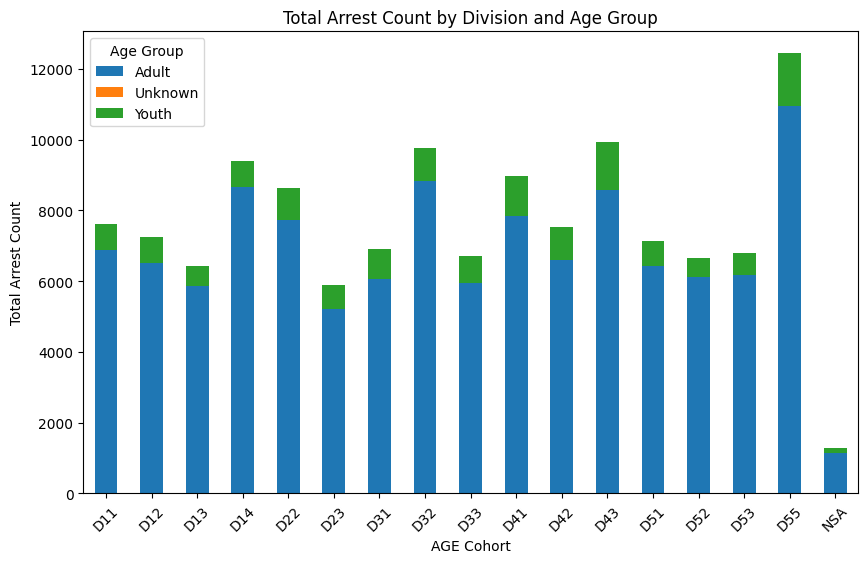

In [ ]:
pivot_grouped_arrest_ageg_count = grouped_arrest_ageg_count.pivot(index='DIVISION', columns='AGE_GROUP', values='Total_Arrest_Count')
pivot_grouped_arrest_ageg_count.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Total Arrest Count by Division and Age Group')
plt.xlabel('AGE Cohort')
plt.ylabel('Total Arrest Count')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.show()

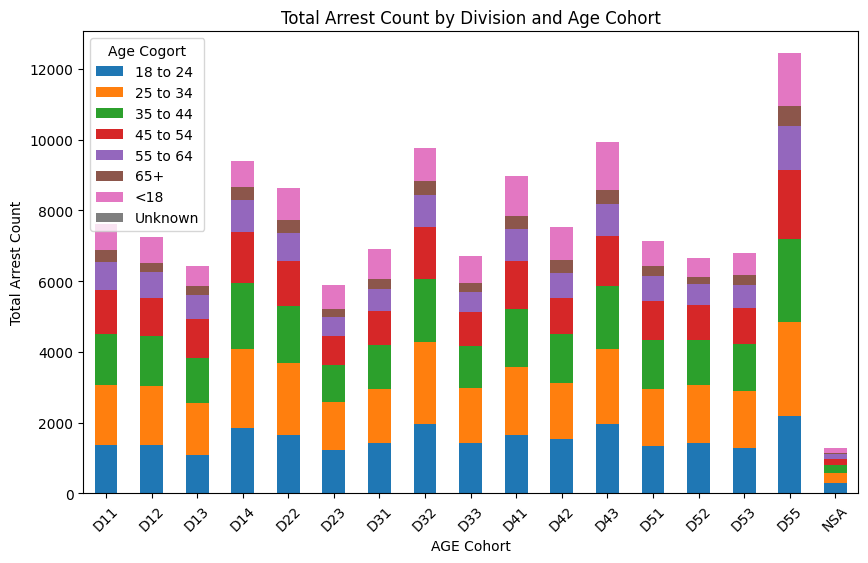

In [ ]:
pivot_grouped_arrest_agec_count = grouped_arrest_agec_count.pivot(index='DIVISION', columns='AGE_COHORT', values='Total_Arrest_Count')
pivot_grouped_arrest_agec_count.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Total Arrest Count by Division and Age Cohort')
plt.xlabel('AGE Cohort')
plt.ylabel('Total Arrest Count')
plt.xticks(rotation=45)
plt.legend(title='Age Cogort')
plt.show()

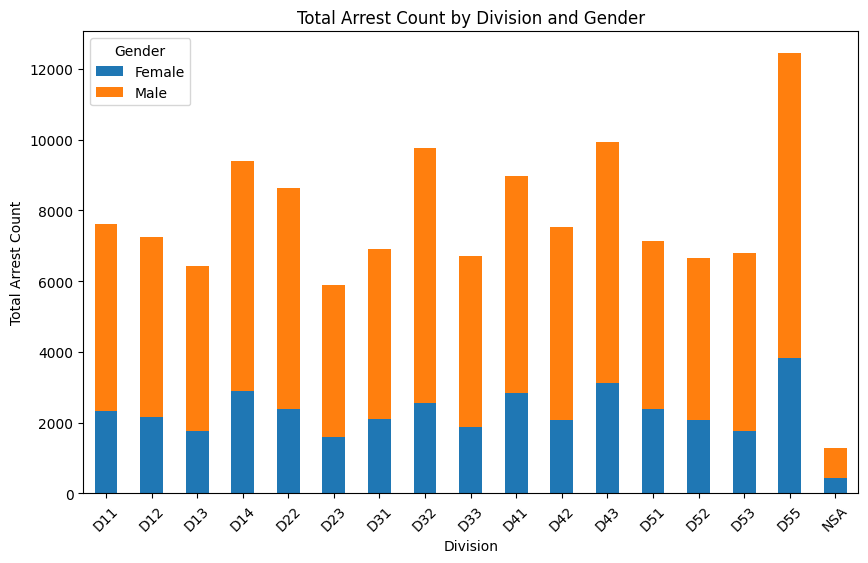

In [ ]:
pivot_grouped_arrest_sex_count = grouped_arrest_sex_count.pivot(index='DIVISION', columns='SEX', values='Total_Arrest_Count')
pivot_grouped_arrest_sex_count.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Total Arrest Count by Division and Gender')
plt.xlabel('Division')
plt.ylabel('Total Arrest Count')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()

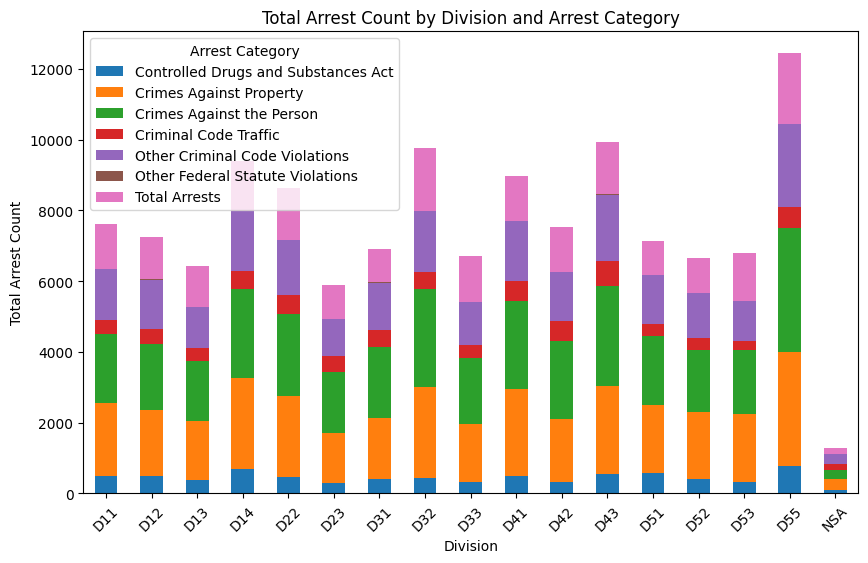

In [ ]:
pivot_grouped_arrest_cat_count = grouped_arrest_cat_count.pivot(index='DIVISION', columns='CATEGORY', values='Total_Arrest_Count')
pivot_grouped_arrest_cat_count.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Total Arrest Count by Division and Arrest Category')
plt.xlabel('Division')
plt.ylabel('Total Arrest Count')
plt.xticks(rotation=45)
plt.legend(title='Arrest Category')
plt.show()

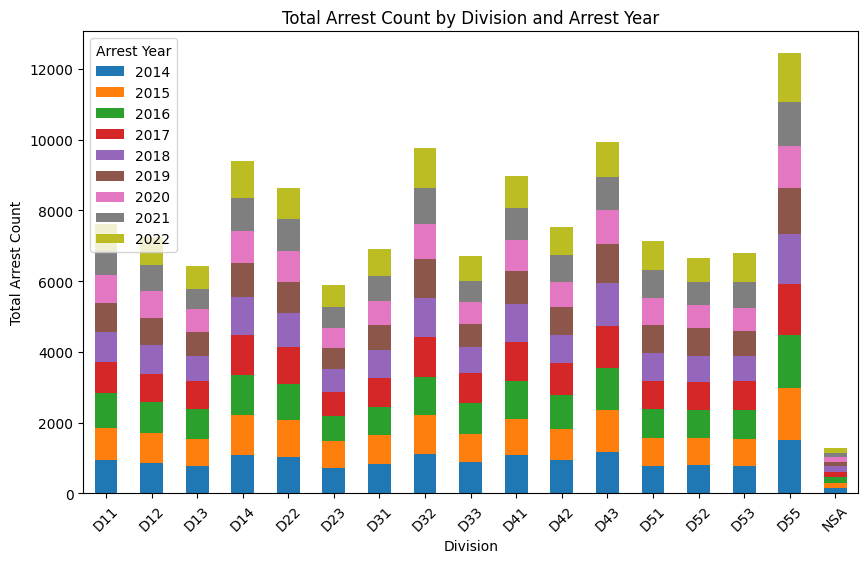

In [ ]:
pivot_grouped_arrest_year_count = grouped_arrest_year_count.pivot(index='DIVISION', columns='ARREST_YEAR', values='Total_Arrest_Count')
pivot_grouped_arrest_year_count.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Total Arrest Count by Division and Arrest Year')
plt.xlabel('Division')
plt.ylabel('Total Arrest Count')
plt.xticks(rotation=45)
plt.legend(title='Arrest Year')
plt.show()